# Todo

# Setup

## Ingest and functions

In [1]:
%%capture

###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['raw_adata', 'full_adata',
             'recluster_0','recluster_1','DE_df']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
usable_cores = multiprocessing.cpu_count()-1

# functions

In [2]:
# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['acral','foreskin','cutaneous']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
dev_subtype_order = ['fet_acral','fet_cutaneous','neo_foreskin','adt_acral','adt_cutaneous']


# Figure 1
High-level overview of data and analysis directions

## Gene module UMAPs

### UMAP

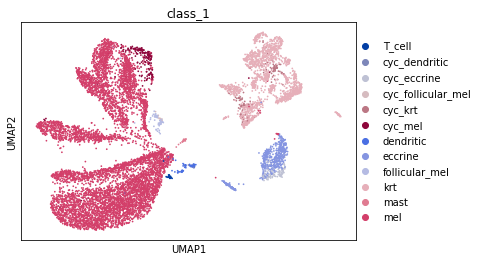

In [3]:
sc.pl.umap(full_adata, color = 'class_1')

### supplemental: cycling cells analysis

#### all cells label by dev stage

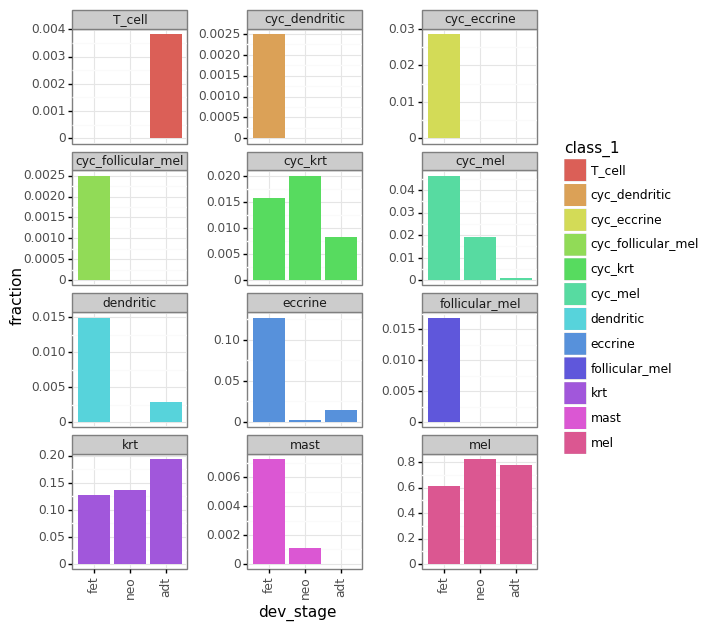

<ggplot: (8749065305015)>


In [4]:
input_adata = full_adata

counts_df = (pd.DataFrame(input_adata
                         .obs
                         .reset_index()
                         .groupby(['dev_stage','class_1'])['index']
                         .count())
             .reset_index()
            )

counts_df['fraction'] = counts_df.groupby('dev_stage')['index'].apply(lambda x: x/sum(x))
counts_df['dev_stage'] = (counts_df['dev_stage']
                          .astype(str)
                          .astype(CategoricalDtype(['fet','neo','adt'], 
                                                   ordered=True)))

plotnine.options.figure_size = (6,6)
print(ggplot(counts_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90),
              aspect_ratio = 1,
              panel_spacing_x = 0.6
             )
      + geom_bar(aes('dev_stage','fraction',fill='class_1'), stat='identity')
      + facet_wrap('~class_1', scales = 'free_y', ncol = 3)
     )


#### cycling vs non-cycling MEL by dev stage or true age

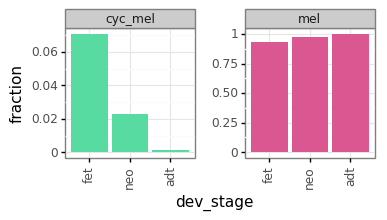

<ggplot: (-9223363287789468591)>


In [5]:
mel_counts = counts_df[[x == 'mel' or x == 'cyc_mel' for x in counts_df['class_1']]]
mel_counts['fraction'] = mel_counts.groupby('dev_stage')['index'].apply(lambda x: x/sum(x))

plotnine.options.figure_size = (4,4)
print(ggplot(mel_counts)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90),
              aspect_ratio = 1,
              panel_spacing_x = 0.5,
              legend_position = 'none'
             )
      + geom_bar(aes('dev_stage','fraction',fill='class_1'), stat='identity')
      + facet_wrap('~class_1', scales = 'free_y', ncol = 3)
     )


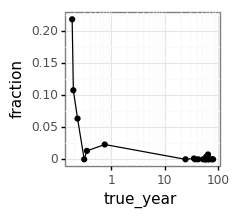

<ggplot: (8749065353981)>


In [6]:
input_adata = full_adata
plot_df = input_adata.obs.loc[:,['class_1','true_year','patient']]
plot_df = plot_df[[x == 'cyc_mel' or x == 'mel' for x in plot_df['class_1']]]
plot_df['class_1'] = plot_df['class_1'].astype(str)
plot_df['patient'] = plot_df['patient'].astype(str)

plot_df = pd.pivot_table(plot_df.groupby(['true_year','class_1']).count().dropna().reset_index(), 
               values = 'patient', 
               index='true_year', 
               columns = 'class_1')
plot_df['fraction'] = plot_df.cyc_mel/plot_df.mel
plot_df = plot_df.fillna(0).reset_index()

plotnine.options.figure_size = (2,2)
print(ggplot(plot_df)
      + theme_bw()
      + geom_line(aes('true_year','fraction'))
      + geom_point(aes('true_year','fraction'))
      + scale_x_log10()
     )


#### cycling MEL vs cycling KRT DE genes

In [7]:
gene_n = 15
input_adata = full_adata[full_adata.obs.dev_stage == 'fet']
clusterOI = 'cyc_mel'
reference= 'cyc_krt'  #'rest'
groupby = 'class_1'

sc.tl.rank_genes_groups(input_adata, groupby=groupby, groups=[clusterOI], method='wilcoxon',reference=reference)
gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
out = symbol2field(gene[:gene_n])
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


querying 1-15...done.
Finished.
0:  TYRP1 
 This gene encodes a melanosomal enzyme that belongs to the tyrosinase family and plays an important role in the melanin biosynthetic pathway. Defects in this gene are the cause of rufous oculocutaneous albinism and oculocutaneous albinism type III. [provided by RefSeq, Mar 2009].
1:  MLANA 
 N/A
2:  EDNRB 
 The protein encoded by this gene is a G protein-coupled receptor which activates a phosphatidylinositol-calcium second messenger system. Its ligand, endothelin, consists of a family of three potent vasoactive peptides: ET1, ET2, and ET3. Studies suggest that the multigenic disorder, Hirschsprung disease type 2, is due to mutations in the endothelin receptor type B gene. Alternative splicing and the use of alternative promoters results in multiple transcript variants. [provided by RefSeq, Oct 2016].
3:  TRPM1 
 This gene encodes a member of the transient receptor potential melastatin subfamily of transient receptor potential ion channels. T

### supplemental: gate assignments

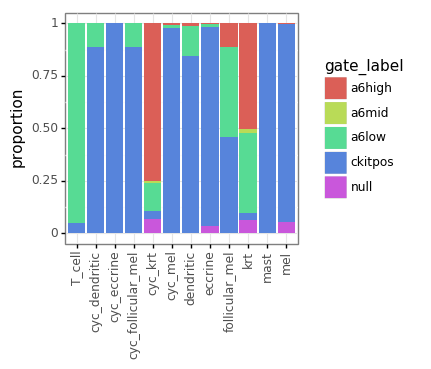

<ggplot: (-9223363287789470811)>

In [8]:
input_adata = full_adata

gate_df = pd.DataFrame(input_adata
             .obs
             .loc[:,['gate_label', 'class_1']]
             .groupby('class_1')['gate_label']
             .value_counts()
            )
          
gate_df = gate_df/gate_df.groupby(level=0).sum()
gate_df = (gate_df
             .rename(columns={'gate_label':'group_prop'})
             .reset_index() 
            )
gate_df['gate_label'] = (gate_df['gate_label']
                                 .astype(str)
                                 .astype(CategoricalDtype(['a6high', 'a6mid', 'a6low', 'ckitpos', 'null'],ordered=True))
                                )

plotnine.options.figure_size = (3,3)
plot = (ggplot(gate_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('class_1','group_prop',fill='gate_label'),stat='identity')
        + labs(x='',y='proportion')
       )
plot

### (decommissioned) Supplemental: 2-feature scatter

In [9]:
# # input_adata = full_adata # all cells
# input_adata = full_adata # mels only

# feat1 = 'NTRK2'
# feat2 = 'true_year'
# groupby = 'dev_subtype'
# alpha = 0.5
# print_metadata_fields = False

# if print_metadata_fields == True:
#     print('possible metadata or grouping features:\n')
#     print(input_adata.obs.columns)
# else:
#     gene = []
#     meta = []
#     tmpdf = pd.DataFrame()

#     for feat in [feat1, feat2]:
#         if feat in input_adata.var_names:
#             cat, exp_df = prepare_dataframe(input_adata,
#                      var_names = feat,
#                      groupby = groupby)
#             tmpdf[feat] = exp_df[feat].values
#         elif feat in input_adata.obs.columns:
#             tmpdf[feat] = input_adata.obs[feat].values

#     tmpdf[groupby] = input_adata.obs[groupby].values

#     plotnine.options.figure_size = (4,4)
#     plot = (ggplot(tmpdf)
#             + theme_bw()
#             + theme(aspect_ratio = 1)
#             + geom_point(aes(feat1, feat2, color = groupby), alpha = alpha)
#            )

#     print(plot)

#     plotnine.options.figure_size = (5,5)
#     plot = (ggplot(pd.melt(tmpdf, id_vars=groupby))
#             + theme_bw()
#             + theme(aspect_ratio = 1,
#                     panel_spacing = 0.4
#                    )
#             + geom_histogram(aes('value', fill = 'variable'), position='dodge')
#             + facet_grid(f'{groupby}~variable', scales = 'free')
#            )

#     print(plot)


## Gene module heatmaps

### cell type by gene module heatmap

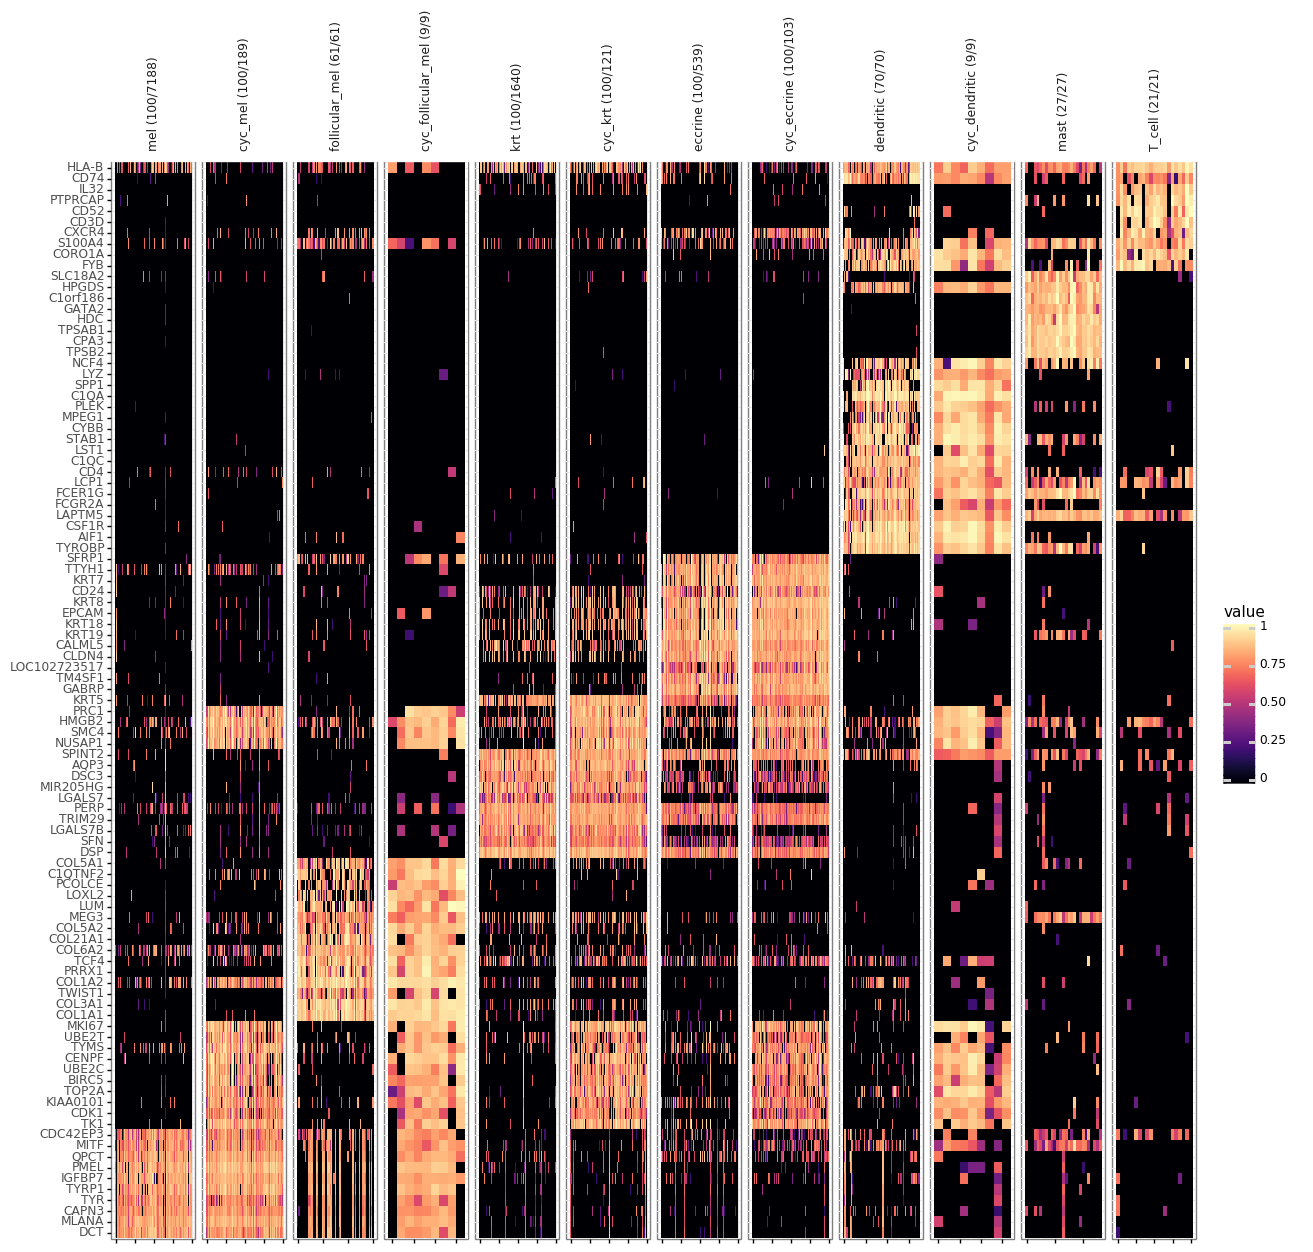

<ggplot: (8749065044400)>

In [10]:
input_adata = full_adata
n_cells = 100

# extract cell types and genes order
type_order = DE_df.class_1.cat.categories.tolist()
gene_order = []
for x in type_order:
    df_slice = DE_df[DE_df.class_1 == x]
    df_slice = df_slice[~df_slice.gene.duplicated(keep='first')]
    gene_order = gene_order + [x for x in df_slice.gene if x not in gene_order]


cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df['class_1'] = input_adata.obs.class_1.tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df.class_1 == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample['class_1'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['class_1','idx'])
compiled_rows_melt['class_1'] = (compiled_rows_melt['class_1']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (14,14)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~class_1', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

plot


### supplemental: MEL-only recluster

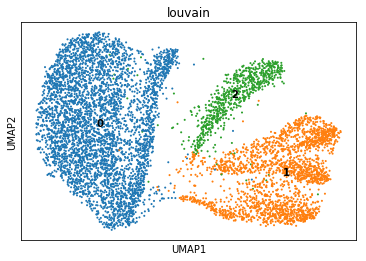

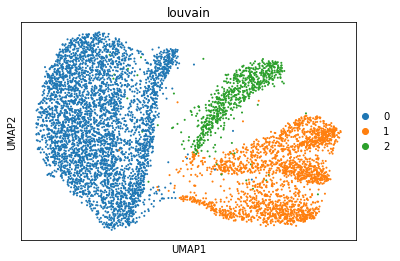

In [11]:
n_pcs = 75
coi = full_adata[full_adata.obs.class_1 == 'mel'].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
adata_subset2 = raw_adata[raw_adata.obs['recluster'] == True]
adata_subset2 = sc.pp.log1p(adata_subset2, copy=True) # new
sc.pp.highly_variable_genes(adata_subset2,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(adata_subset2) # new
sc.tl.pca(adata_subset2, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(adata_subset2, n_pcs=n_pcs, n_neighbors=100) # new
sc.tl.umap(adata_subset2, min_dist = 0.5)
sc.tl.louvain(adata_subset2, resolution = 0.3)
sc.pl.umap(adata_subset2, color=['louvain'], legend_loc='on data')
sc.pl.umap(adata_subset2, color=['louvain'])


### supplemental: PCA-based feature analysis

##### Tukey test and recluster

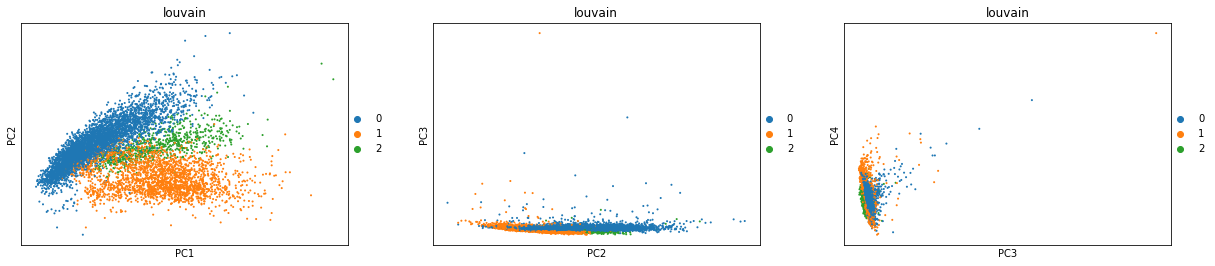

Filtered cells:  428
Fraction filtered:  0.05954368391764051


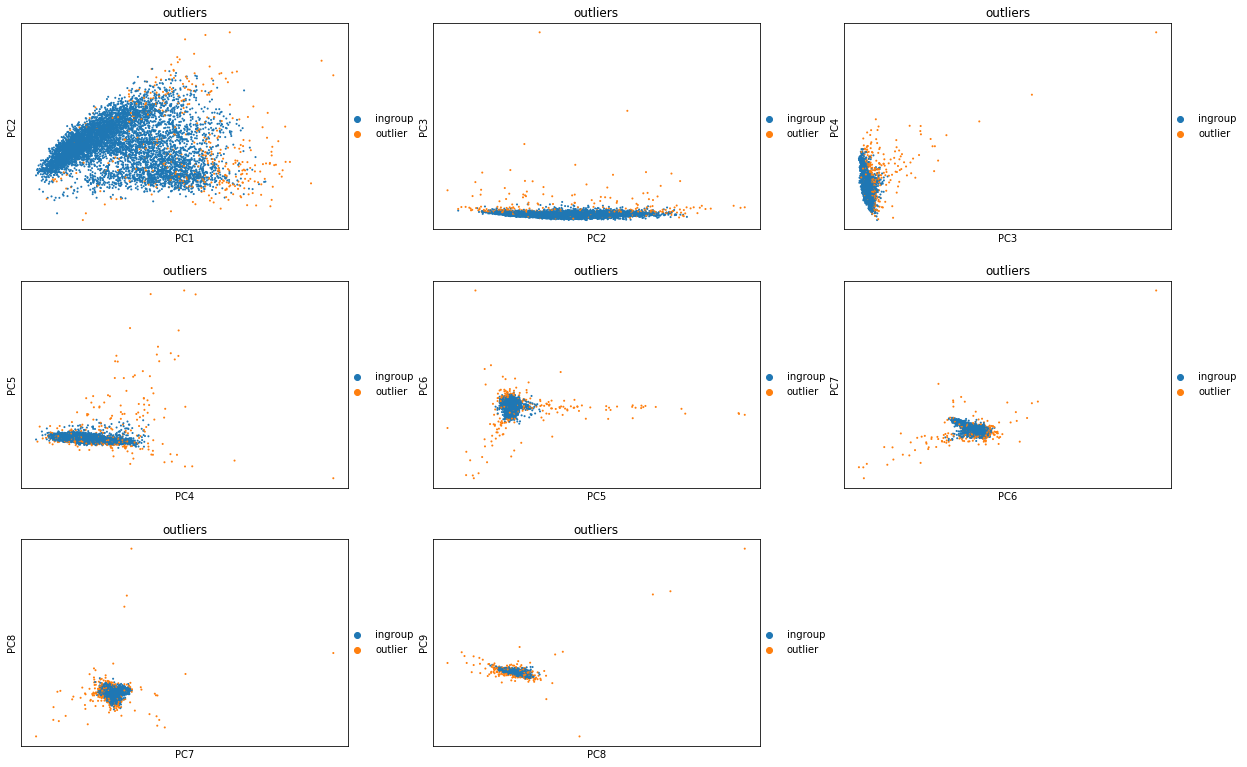

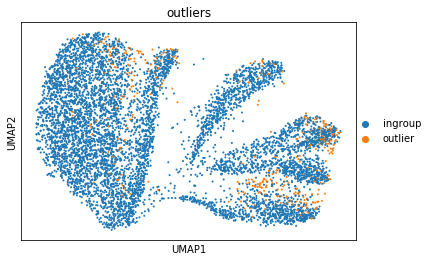

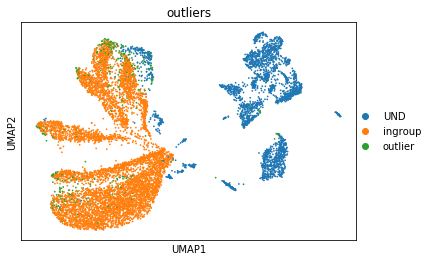

key = outliers, value = ingroup, matched = 6760
	Cells: 6760, Genes: 24572


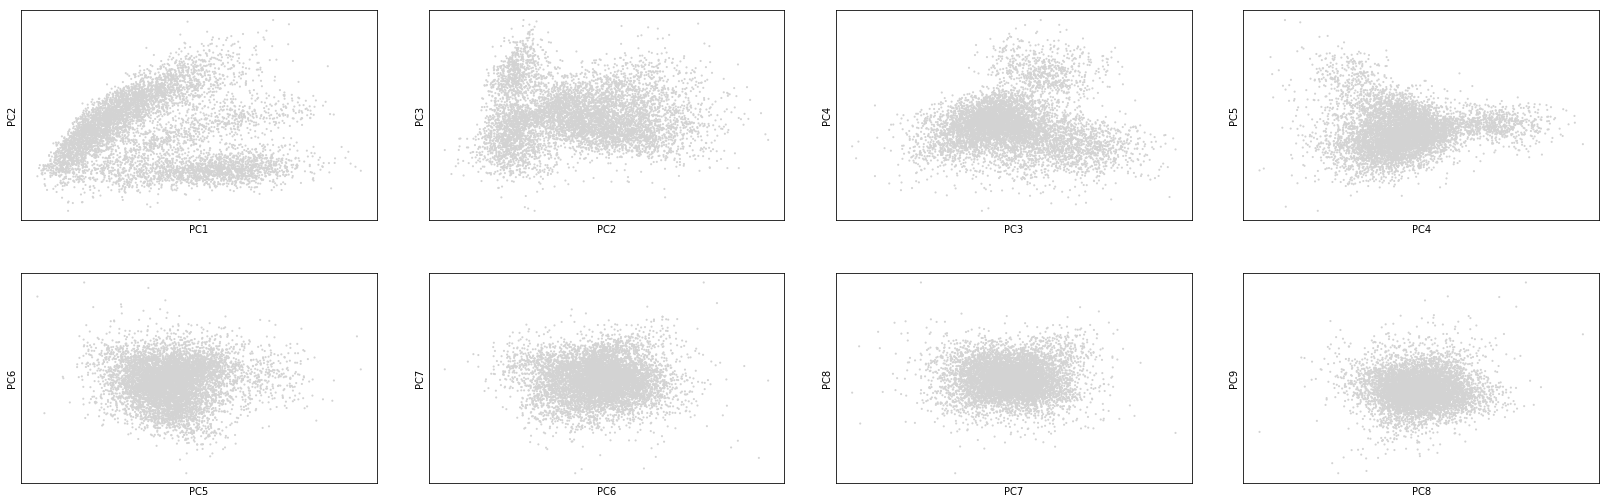

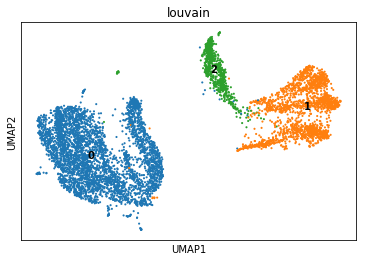

In [12]:
# initial PC coordinates
cutoff = 5
n_pcs = 75
input_adata = adata_subset2
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(input_adata.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(n_pcs)]

omit_names = []
for pc in df.columns:
#     print(len(set(omit_names)))
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1

    bool_idx = [(Q1 - (cutoff * IQR)) > x or x > (Q3 + (cutoff * IQR)) for x in df[pc]]
    filtered = df[bool_idx]
#     print('Filtered cells: ', len(df)-len(filtered))
    
    omit_names = omit_names + input_adata.obs[bool_idx].index.tolist()

print('Filtered cells: ', len(set(omit_names)))
print('Fraction filtered: ', len(set(omit_names))/len(input_adata.obs) )

# check where the outliers lie in original projection
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
components = ['1,2', '2,3','3,4','4,5','5,6','6,7','7,8','8,9']
sc.pl.pca(input_adata, components=components, color=['outliers'], ncols =3)
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# outliers on all-cells projection
type_dict = {'ingroup':['ingroup'],
             'outlier':['outlier']}
    
classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'outliers')

sc.pl.umap(full_adata, color = ['outliers'])

# recompute PCA and clustering
n_pcs = 100

feature_dict = {'outliers':['ingroup']}
adata_subset2_trimmed = subset_adata_v3(raw_adata,feature_dict)
sc.pp.log1p(adata_subset2_trimmed) # new
sc.pp.highly_variable_genes(adata_subset2_trimmed,min_mean=0.5,max_mean=10,min_disp=0.5) # new
sc.pp.scale(adata_subset2_trimmed) # new
sc.tl.pca(adata_subset2_trimmed, use_highly_variable = True, n_comps=n_pcs) # new
sc.pl.pca(adata_subset2_trimmed, components=components)
sc.pp.neighbors(adata_subset2_trimmed,n_pcs=n_pcs) # new
sc.tl.umap(adata_subset2_trimmed, min_dist = 0.25)
sc.tl.louvain(adata_subset2_trimmed, resolution = 0.2)
sc.pl.umap(adata_subset2_trimmed, color=['louvain'], legend_loc='on data')

# add feature labels
for input_adata in [adata_subset2_trimmed]:
    input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
    input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

    input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
    input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
    input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
    input_adata.obs['foreskin_subtype'] = [x if x == 'foreskin' else 'not_foreskin' for x in input_adata.obs['subtypes']]
    input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]

    
    for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'foreskin_subtype', 'dev_subtype']:
        input_adata.obs[i] =  (input_adata
                                 .obs[i]
                                 .astype(str)
                               .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
                              )

##### outlier DE analysis

In [ ]:
input_adata = adata_subset2
clusterOI = 'outlier'
reference= 'ingroup'  #'rest'
groupby = 'outliers'

sc.tl.rank_genes_groups(input_adata, groupby=groupby, groups=[clusterOI], method='wilcoxon',reference=reference)
gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
out = symbol2field(gene[:50])
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


In [14]:
# top10 genes:
gene[:10]

['GAPDH',
 'RPL3',
 'PTMA',
 'PFN1',
 'PPIA',
 'RPL15',
 'RPL35',
 'RPLP2',
 'RPS12',
 'RPL13A']

#### logistic regression for feature analysis using PC space
- logistic regression trained on PCs to classify feature labels
    - top 2 models with highest accuracy (f1 statistic) are identified for visualization

##### logistic regression

  0%|          | 0/45 [00:00<?, ?it/s]

dev_stage


100%|██████████| 45/45 [00:18<00:00,  2.34it/s]


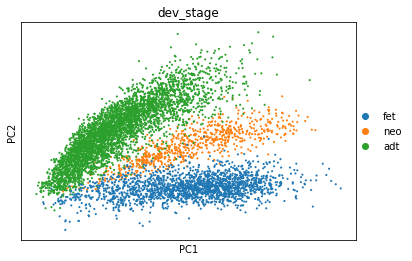

  0%|          | 0/45 [00:00<?, ?it/s]

subtypes


100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


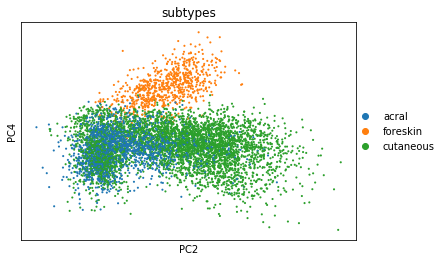

  0%|          | 0/45 [00:00<?, ?it/s]

acral_subtype


100%|██████████| 45/45 [00:17<00:00,  2.49it/s]


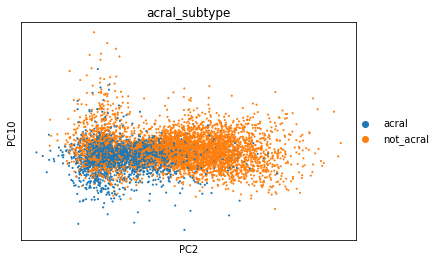

  0%|          | 0/45 [00:00<?, ?it/s]

foreskin_subtype


100%|██████████| 45/45 [00:17<00:00,  2.48it/s]


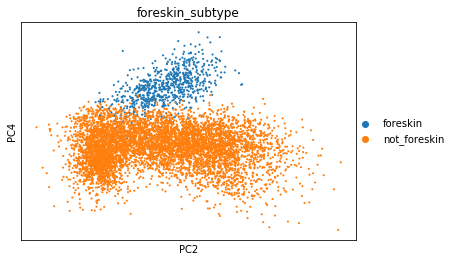

In [15]:
# enforce class balance
sample_n = 1500
pc_n = 10
input_adata = adata_subset2_trimmed
label_groups = ['dev_stage','subtypes','acral_subtype','foreskin_subtype']
# label_groups = ['dev_stage']


master_df = pd.DataFrame()
for key in label_groups:
    print(key)
    
    acc_list = []
    PCA_list = []
    PCB_list = []
    for PC_tup in tqdm.tqdm([x for x in combinations([x for x in range(pc_n)],2)]):
        
        labels = list(set(input_adata.obs[key]))
        label_master = []
        PCA = PC_tup[0]
        PCB = PC_tup[1]
        PCA_coord = []
        PCB_coord = []
        
        for label in labels:
            input_slice = input_adata[input_adata.obs[key] == label]
            sample_idx = random.choices(range(len(input_slice)), k = sample_n)
            label_slice = [label]*sample_n
            label_master = label_master + label_slice
            PCA_coord = PCA_coord + input_slice.obsm['X_pca'][:,PCA][sample_idx].tolist()
            PCB_coord = PCB_coord + input_slice.obsm['X_pca'][:,PCB][sample_idx].tolist()
        
        pc_master = np.zeros((sample_n*len(labels),2))
        pc_master[:,0] = PCA_coord
        pc_master[:,1] = PCB_coord
            
        acc = pca_logistic(pred = pc_master, res = np.array(label_master))
        acc_list.append(acc)
        PCA_list.append(PCA)
        PCB_list.append(PCB)
        
        df_slice = pd.DataFrame({'PCA':[x+1 for x in PCA_list],
                                 'PCB':[x+1 for x in PCB_list],
                                 'f1':acc_list}
                               )
        df_slice['label_group'] = key

    master_df = master_df.append(df_slice)

    comps = (master_df[master_df.label_group == key]
             .sort_values('f1', ascending = False)
             .iloc[0:1,:]
             .loc[:,['PCA','PCB']]
             .values
             .flatten()
             .tolist()
            )
    sc.pl.pca(input_adata, color = [key], components=comps)
        

##### PC loadings gene list

acral pc loadings


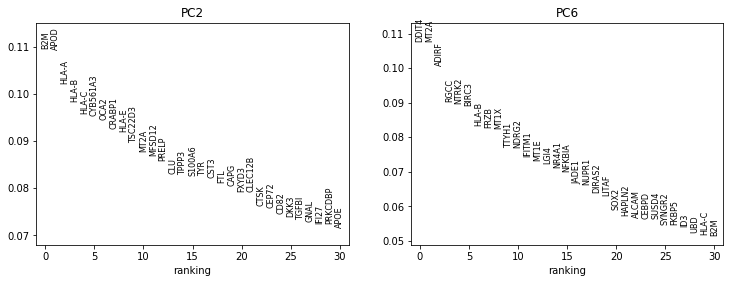

forskin pc loadings


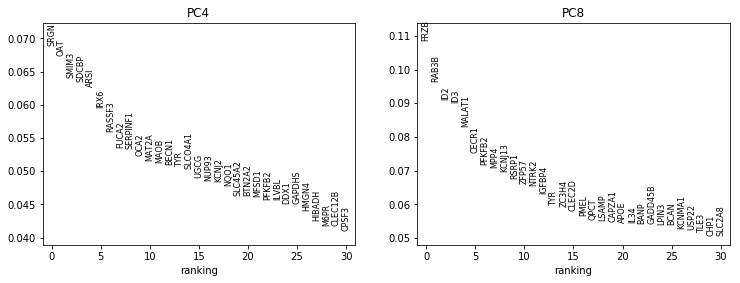

In [16]:
input_adata = adata_subset2_trimmed
print('acral pc loadings')
sc.pl.pca_loadings(input_adata, components = [2,6])
print('forskin pc loadings')
sc.pl.pca_loadings(input_adata, components = [4,8])

##### (decommissioned) dev_subtype covariance matrix

In [17]:
# ### correlation of bulkized expression vectors
# input_adata = adata_subset2_trimmed
# groupby = 'dev_subtype'
# high_var_genes = (input_adata.var['highly_variable'] \
#                   [input_adata.var['highly_variable'] == True]).index.tolist()

# cat, df = prepare_dataframe(input_adata,
#                             high_var_genes,
#                             groupby
#                            )

# corr_df = df.reset_index()
# corr_df[groupby] = corr_df[groupby].astype(str)
# corr_df = corr_df.groupby(groupby).mean().T.corr('spearman') ** 2
# corr_df = corr_df.reset_index()
# corr_df = pd.melt(corr_df, id_vars=groupby, var_name = 'variable')

# plotnine.options.figure_size = (3,3)
# print(ggplot(corr_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_tile(aes(groupby, 'variable', fill = 'value'))
#       + geom_text(aes(groupby, 'variable', label = 'value'), 
#                   format_string='{:.2f}', color = 'grey')
#       + scale_fill_cmap('magma')
#      )


##### Expression overlay on PC embeddings

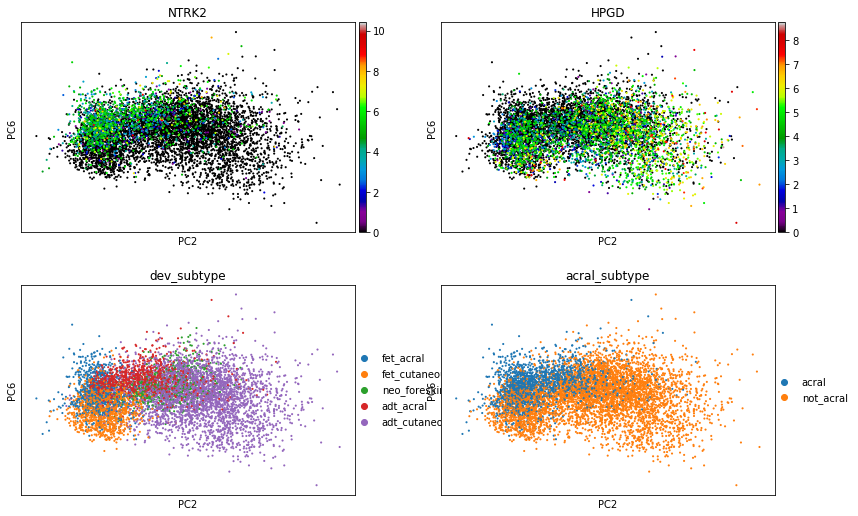

In [18]:
input_adata = adata_subset2_trimmed
sc.pl.pca(input_adata, color = ['NTRK2','HPGD','dev_subtype','acral_subtype'], components=[2,6], ncols = 2, cmap = 'nipy_spectral')


# Figure 2: Age differences

## Adult vs. fetal differential expression in MELs

### MWU tests
- iterative downsampling used to overcome machine precision limit on p-values

In [227]:
n_print = 10
run_me = True

adt_v_fet_DE = pd.DataFrame()
cell_type_key = {'mel':adata_subset2_trimmed,'krt':full_adata[full_adata.obs.class_1 == 'krt']}
for cell_type in ['mel', 'krt']:
    input_adata = cell_type_key[cell_type]
    genes = input_adata.var_names.tolist()
    cat, prep_slice = prepare_dataframe(input_adata,
                                         var_names = genes,
                                         groupby = 'dev_stage')
    for i in ['greater', 'less']:
        if run_me == True:
            print(f'fetal {cell_type} {i} than adult {cell_type}:')

            frac = 1
            n_uncert = 1
            while n_uncert > 0:

                fet_slice = (prep_slice[[x == 'fet' for x in prep_slice.index]]
                             .sample(frac=frac))
                adt_slice = (prep_slice[[x == 'adt' for x in prep_slice.index]]
                             .sample(frac=frac))

                print(f'Testing downsample fraction = {frac}')
                stat_pval_tuple = parallel_mwu(genes, 
                                           fet_slice, 
                                           adt_slice, 
                                           i, 
                                           usable_cores)
                stat_list = stat_pval_tuple[0]
                pval_list = stat_pval_tuple[1]
                results_df = pd.DataFrame({'gene':genes,
                                         'stat_1':stat_list,
                                         'pval_1':pval_list,
                                        })
                results_df['frac'] = frac
                results_df['test'] = f'fetal {i} than adult'
                results_df['cell_type'] = cell_type
                n_uncert = sum(results_df['pval_1'] == 0)
                frac /= 2
            print(f'downsample fraction: {frac}')
            adt_v_fet_DE = adt_v_fet_DE.append(results_df)
        if len(adt_v_fet_DE) != 0:
            filtered_df = adt_v_fet_DE[[x == f'fetal {i} than adult' and y == cell_type \
                                        for x,y in zip(adt_v_fet_DE.test,adt_v_fet_DE.cell_type)]]
            print_df = (filtered_df
                        .dropna()
                        .sort_values('pval_1')
                        .head(10))
            display(print_df)


fetal mel greater than adult mel:
Testing downsample fraction = 1
Testing downsample fraction = 0.5
Testing downsample fraction = 0.5
Testing downsample fraction = 0.25
downsample fraction: 0.125


,gene,stat_1,pval_1,frac,test,cell_type
8012,HLA-B,40067.0,1.819595e-163,0.25,fetal less than adult,mel
968,APOD,35029.0,2.992840e-162,0.25,fetal less than adult,mel
4025,CRABP1,52618.5,4.418591e-148,0.25,fetal less than adult,mel
9737,LGALS3,61161.0,2.862478e-125,0.25,fetal less than adult,mel
8013,HLA-C,67481.5,4.287794e-120,0.25,fetal less than adult,mel
3044,CD59,73592.5,5.253990e-109,0.25,fetal less than adult,mel
3703,CLU,95236.0,6.372124e-103,0.25,fetal less than adult,mel
1496,B2M,78796.0,9.074528e-103,0.25,fetal less than adult,mel
14366,MT2A,80604.5,5.976874e-102,0.25,fetal less than adult,mel
8011,HLA-A,79668.5,8.783687e-102,0.25,fetal less than adult,mel


fetal krt greater than adult krt:
Testing downsample fraction = 1
downsample fraction: 0.5


,gene,stat_1,pval_1,frac,test,cell_type
20590,SOX11,460090.5,2.871392e-270,1.0,fetal greater than adult,krt
12895,MEG3,465056.0,1.683773e-269,1.0,fetal greater than adult,krt
8477,IGF2,449177.5,7.183132e-255,1.0,fetal greater than adult,krt
7917,HIF3A,436178.5,1.275281e-232,1.0,fetal greater than adult,krt
9438,KRT19,434707.0,2.667432e-224,1.0,fetal greater than adult,krt
12717,MARCKSL1,460972.0,1.292571e-213,1.0,fetal greater than adult,krt
12837,MDK,438766.5,4.010491e-211,1.0,fetal greater than adult,krt
9436,KRT18,428851.0,3.030601e-201,1.0,fetal greater than adult,krt
9477,KRT8,422689.5,1.050838e-200,1.0,fetal greater than adult,krt
9434,KRT17,450805.0,6.193209e-190,1.0,fetal greater than adult,krt


fetal krt less than adult krt:
Testing downsample fraction = 1
downsample fraction: 0.5


,gene,stat_1,pval_1,frac,test,cell_type
8012,HLA-B,5964.0,6.085150e-206,1.0,fetal less than adult,krt
8013,HLA-C,19054.0,3.429098e-183,1.0,fetal less than adult,krt
1496,B2M,19199.5,6.220148e-180,1.0,fetal less than adult,krt
8011,HLA-A,20212.0,1.440223e-179,1.0,fetal less than adult,krt
2448,CA12,27183.5,7.476257e-176,1.0,fetal less than adult,krt
512,AHNAK2,24711.5,2.918065e-175,1.0,fetal less than adult,krt
14365,MT1X,23696.0,1.348115e-174,1.0,fetal less than adult,krt
12461,LY6D,27781.0,3.309847e-171,1.0,fetal less than adult,krt
8033,HLA-H,45548.5,9.281707e-150,1.0,fetal less than adult,krt
8128,HOPX,46511.0,2.203211e-143,1.0,fetal less than adult,krt


### heatmap of DE genes: fet vs adt

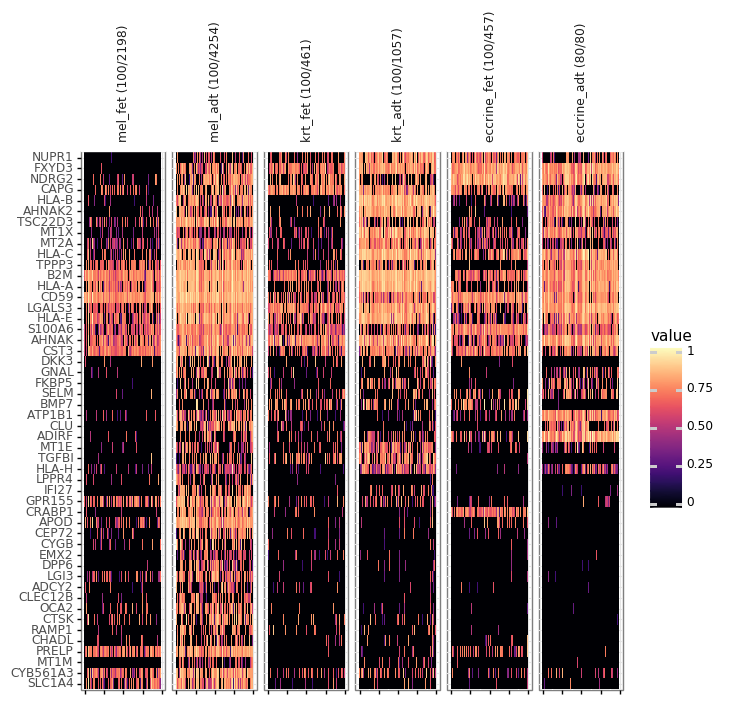

<ggplot: (-9223363288173633287)>


In [244]:
gene_n = 50
cell_type = 'mel'
# cell_type = 'krt'
# test_type = 'fetal greater than adult'
test_type = 'fetal less than adult'
clust_dict = {'fetal less than adult':5,
              'fetal greater than adult':3
             }
n_clust = clust_dict.get(test_type)

results = (adt_v_fet_DE[[x == cell_type and y == test_type for x,y in zip(adt_v_fet_DE.cell_type, adt_v_fet_DE.test)]]
             .sort_values('pval_1')
            )
# display(results.head(gene_n))

gene_order = results.gene.tolist()[:gene_n]
input_adata = full_adata
n_cells = 100
groupby = 'class_stage'
input_adata.obs[groupby] = [f'{x}_{y}' for x,y in zip(input_adata.obs['class_1'],input_adata.obs['dev_stage'])]

type_order = ['mel_fet','mel_adt','krt_fet','krt_adt','eccrine_fet','eccrine_adt']

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df[groupby] = input_adata.obs[groupby].tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df[groupby] == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample[groupby] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
### gene clustering
data = compiled_rows.iloc[:,:-2].T.values

cluster = AgglomerativeClustering(n_clusters=n_clust, 
                                  affinity='euclidean', 
                                  linkage='ward')  
labels = cluster.fit_predict(data).tolist()
label_df = pd.DataFrame({'gene':compiled_rows.iloc[:,:-2].columns.values,
                         'label':labels})
gene_order = label_df.sort_values('label').gene.tolist()
###

compiled_rows_melt = pd.melt(compiled_rows, id_vars=[groupby,'idx'])
compiled_rows_melt[groupby] = (compiled_rows_melt[groupby]
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (7,7)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid(f'~{groupby}', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

print(plot)


### gene look-up

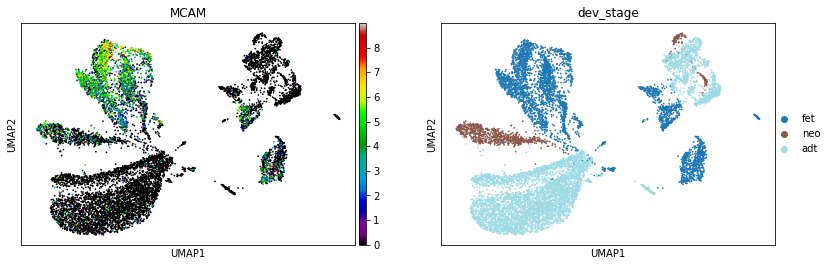

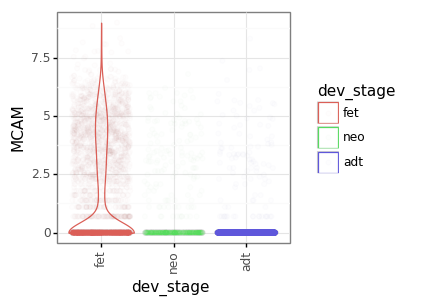

<ggplot: (-9223363288104408646)>
querying 1-1...done.
Finished.
0:  MCAM 
 N/A


In [131]:
# look up gene
gene = 'MCAM'
groupby = 'dev_stage'
input_adata = full_adata

sc.pl.umap(input_adata, color = [gene,groupby], cmap='nipy_spectral', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )

plot_df = plot_df.reset_index().dropna()
plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_violin(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


## (decommissioned) Age rank correlations in MELs
n_genes correlation computed for control

### (decommissioned) spearman correlation

In [154]:
# n_print = 20

# ### select MEL vs KRT ###
# input_adata = adata_subset2_trimmed
# # input_adata = adata_subset1_KRT

# ### select adt vs fet ###
# # dev_stage = 'adt'
# dev_stage = 'fet'

# ### select acral vs cutaneous ###
# # subtype = 'acral'
# subtype = 'cutaneous'

# print(f'{dev_stage} {subtype} age correlation')

# input_adata = input_adata[[x == dev_stage and y == subtype \
#                            for x,y in zip(input_adata.obs.dev_stage, 
#                                           input_adata.obs.subtypes)]]

# groupby = 'patient'
# cat, gene_df = prepare_dataframe(input_adata,
#                                  input_adata.var_names.tolist(),
#                                  groupby
#                                 )
# gene_df = gene_df.transform(lambda x: np.log1p(x))

# age_vec = input_adata.obs['true_year'].values
# ngenes_vec = input_adata.obs['n_genes'].values

# stat1_list = []
# pval1_list = []
# stat2_list = []
# pval2_list = []
# gene_list = []
# for i in input_adata.var_names.tolist():
#     gene_vec = gene_df.loc[:, i].values
#     stat1, pval1 = stats.spearmanr(age_vec, gene_vec)
#     stat2, pval2 = stats.spearmanr(ngenes_vec, gene_vec)
#     stat1_list.append(stat1)
#     pval1_list.append(pval1)
#     stat2_list.append(stat2)
#     pval2_list.append(pval2)
#     gene_list.append(i)
    
# corr_df = pd.DataFrame({'gene':gene_list,
#                         'stat_1':stat1_list,
#                         'pval_1':pval1_list,
#                         'stat_2':stat2_list,
#                         'pval_2':pval2_list
#                        })
# display(corr_df.sort_values('pval_1').head(n_print))


fet cutaneous age correlation


,gene,stat_1,pval_1,stat_2,pval_2
18739,RPS27,-0.763534,1.865264e-197,-0.381683,4.614919e-37
22201,TMSB4X,-0.762552,1.181121e-196,-0.409776,5.585947e-43
18742,RPS28,-0.747187,1.328161e-184,-0.361176,4.297381e-33
18727,RPS18,-0.742708,2.971869e-181,-0.372119,3.554956e-35
18675,RPL36,-0.739028,1.491459e-178,-0.338636,4.718507e-29
18729,RPS19,-0.736927,4.955262e-177,-0.347446,1.360278e-30
18680,RPL37A,-0.733879,7.516381e-175,-0.299661,8.169801e-23
18643,RPL21,-0.733263,2.056783e-174,-0.390195,8.536322e-39
18737,RPS26,-0.732838,4.114612e-174,-0.295460,3.391916e-22
18679,RPL37,-0.729206,1.454247e-171,-0.296770,2.181895e-22


### (decommissioned) gene lookup

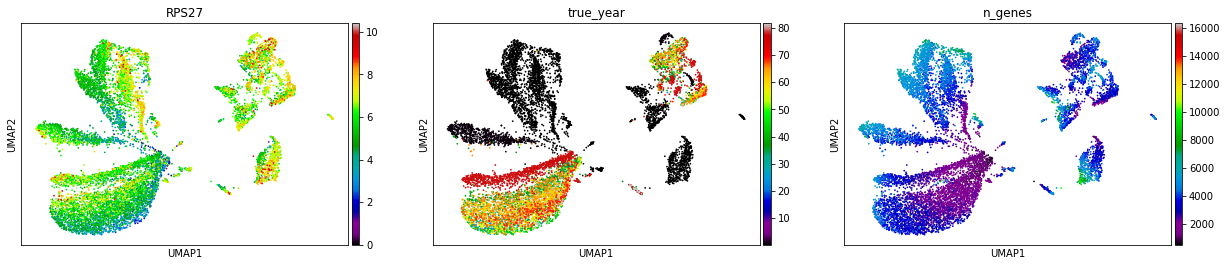

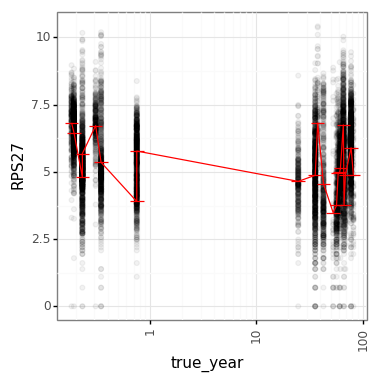

<ggplot: (-9223363287997641770)>


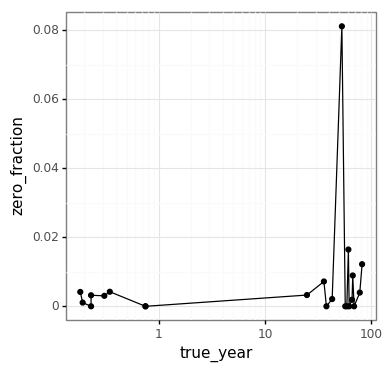

<ggplot: (8748857127919)>
querying 1-1...done.
Finished.
0:  RPS27 
 Ribosomes, the organelles that catalyze protein synthesis, consist of a small 40S subunit and a large 60S subunit. Together these subunits are composed of four RNA species and approximately 80 structurally distinct proteins. This gene encodes a member of the S27e family of ribosomal proteins and component of the 40S subunit. The encoded protein contains a C4-type zinc finger domain that can bind to zinc and may bind to nucleic acid. Mutations in this gene have been identified in numerous melanoma patients and in at least one patient with Diamond-Blackfan anemia (DBA). Elevated expression of this gene has been observed in various human cancers. As is typical for genes encoding ribosomal proteins, there are multiple processed pseudogenes of this gene dispersed through the genome. [provided by RefSeq, Jul 2018].


In [156]:
# # look up gene
# input_adata = full_adata
# gene = 'RPS27'

# sc.pl.umap(input_adata, color = [gene, 'true_year', 'n_genes'], cmap='nipy_spectral')
# groupby = 'patient'
# cat, plot_df = prepare_dataframe(input_adata,
#                             gene,
#                             groupby
#                            )
# plot_df['true_year'] =  input_adata.obs.true_year.tolist()
# plotnine.options.figure_size = (4,4)
# print(ggplot(plot_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_point(aes('true_year',gene), alpha = 0.05)
#       + geom_point(plot_df.reset_index().groupby('patient').mean(), aes('true_year',gene), 
#                    shape = '_', color = 'red', size = 5)
#       + geom_line(plot_df.reset_index().groupby('patient').mean(), aes('true_year',gene), 
#                    color = 'red')
#       + scale_x_log10()
#      )

# print(ggplot(pd.DataFrame(plot_df
#                      .reset_index()
#                      .groupby('patient')[gene]
#                      .apply(lambda x: zero_fraction(x))
#                     )
#                      .assign(true_year = plot_df.reset_index()
#                                                            .groupby('patient')
#                                                            .mean()
#                                                            .true_year)
#                      .rename(columns = {gene:'zero_fraction'}))
#       + theme_bw()
#       + geom_point(aes('true_year','zero_fraction'))
#       + geom_line(aes('true_year','zero_fraction'))
#       + scale_x_log10()
#      )

# out = symbol2field(gene)
# output = [print(f'{idx}: ', 
#        x['query'],
#        '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                 x['query'],
#                                                                 '\n','N/A') for idx, x in enumerate(out)]


## (decommissioned) MEL- or KRT-specific adult vs. fetal differential expression
- Identify differentially-expressed genes unique to cell type

### (decommissioned) Determine difference in MWU adult vs fetal test p-values between cell types
- Normalize against fetal vs adult KRT DE genes

#### (decommissioned) MWU test and ad hoc subtraction

In [ ]:
# # correlate KRT vs MEL to determine unique development program
# n_print = 20
# sort_term = 'mel'
# i = 'less' #'fetal {i} than adult'
# ref1 = 'krt' # baseline for normalization
# ref2 = 'mel'
# delta_cutoff = 0.9
# DE_cutoff = 0.2

# print(f'fetal {sort_term} {i} than adult {sort_term}, normalized by {ref1}. Minimum differential expression percentile = {DE_cutoff}')
# print(f'Minimum squared difference between {ref2} and {ref1} percentile = {delta_cutoff}')

# # Ranked MWU p-values
# for idx, ref in enumerate([ref1, ref2]):
#     vec = ((adt_v_fet_DE[[x == ref and y == f'fetal {i} than adult' for x,y in zip(adt_v_fet_DE.cell_type, 
#                                                                                                adt_v_fet_DE.test)]]
#                     .sort_values('gene')
#                     .fillna(1)
#                     .assign(pval_1 = lambda x: 1-x.pval_1.rank(pct = True))
#                 )['pval_1']
#                 .values
#                 .reshape(-1,1))
#     ref_idx = idx + 1
#     exec(f'ref{ref_idx}_vec = vec')

# plot_df = pd.DataFrame({ref1:ref1_vec.flatten(),
#                         ref2:ref2_vec.flatten(),
#                        })

# plot_df['gene'] = sorted(list(set(adt_v_fet_DE.gene)))
# plot_df['delta'] = plot_df[ref1] - plot_df[ref2]
# plot_df['sq_delta'] = plot_df['delta'] ** 2
# plot_df['ranked_sq_delta'] = plot_df['sq_delta'].rank(pct = True)
# plot_df = plot_df[[x > DE_cutoff and y > DE_cutoff \
#                    for x,y in zip(plot_df.mel,plot_df.krt)]]

# plotnine.options.figure_size = (3,3)
# print(ggplot(plot_df)
#       + theme_bw()
#       + geom_histogram(aes('ranked_sq_delta'))
#       + geom_vline(aes(xintercept = delta_cutoff), color = 'red', linetype = '--')
#      )

# print_df = (plot_df[plot_df['ranked_sq_delta'] > delta_cutoff]
#             .sort_values(sort_term, ascending=False)
#             .head(n_print))
# display(print_df)
# glist = print_df.gene.tolist()

# plotnine.options.figure_size = (3,3)
# print(ggplot(plot_df)
#       + theme_bw()
#       + geom_bin2d(aes(ref1, ref2))
#       + geom_bin2d(plot_df[plot_df['ranked_sq_delta'] <= DE_cutoff], aes(ref1,ref2), fill = 'grey', alpha = 0.7)
#       + scale_fill_cmap('nipy_spectral')
#       + ggtitle(f'fetal {i} than adult')
#       + labs(x = f'{ref1} ranked MWU p-value',
#              y = f'{ref2} ranked MWU p-value'
#             )
#      )


### (decommissioned) Geneset enrichment of top genes

In [ ]:
# # determine the geneset of top genes
# results = geneset_lookup(glist)
# results.filter(items = ['Term','Overlap','Adjusted P-value','Genes','Gene_set']).head(10)


### (decommissioned) DEV: fetal scoring 

In [ ]:
# # filter: fetal gene median expression > 0 and adult gene median expression == 0

# ### MUST run above section: MWU test and ad hoc subtraction

# print_n = 10

# input_adata = adata_subset2_trimmed
# genes = input_adata.var_names.tolist()
# cat, prep_slice = prepare_dataframe(input_adata,
#                                      var_names = genes,
#                                      groupby = 'dev_stage')

# df = (prep_slice
#       .reset_index()
#       .groupby('dev_stage')
#       .median()
#       .reset_index()
#      )

# df['dev_stage'] = df['dev_stage'].astype(str)
# df = df[df.dev_stage != 'neo']
# df = df.set_index('dev_stage').T
# df['pass'] = [x > y and y == 0 for x,y in zip(df.fet, df.adt)]
# df = df.reset_index().rename(columns ={'index':'gene'})
# df = pd.merge(print_df, df, 'left', 'gene')

# display(df[df['pass'] == True].head(print_n))


In [ ]:
# fetal scoring module
gene_n = 10
fet_genes = df[df['pass'] == True].head(gene_n)['gene'].tolist()
input_adata = adata_subset2_trimmed
input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = fet_genes,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

input_adata.obs['FET_score'] = exp_df.loc[:,fet_genes].mean(axis=1)

sc.pl.umap(input_adata, color=['FET_score','n_genes','true_year'], 
           ncols = 3, cmap = 'magma', palette = 'tab20')

print(ggplot(input_adata.obs.loc[:,['FET_score','dev_subtype']])
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('dev_subtype','FET_score'))
      + geom_jitter(aes('dev_subtype','FET_score'), 
                    alpha = 0.01, width = 0.25)
     )


In [ ]:
print(ggplot(input_adata.obs.loc[:,['FET_score','dev_subtype']])
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_density(aes('FET_score'))
      + facet_wrap('~dev_subtype')
     )

In [ ]:
# correlation to n_genes

fet_genes = df[df['pass'] == True].head(gene_n)['gene'].tolist()
input_adata = adata_subset2_trimmed[adata_subset2_trimmed.obs.age > 0]
input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = fet_genes,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

input_adata.obs['FET_score'] = exp_df.loc[:,fet_genes].mean(axis=1)
plot_df = input_adata.obs.loc[:,['n_genes','FET_score']]
results = plot_df.corr('spearman') ** 2
display(results)

print(ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes('n_genes','FET_score'))
     )


### (decommissioned) DEV: adult scoring 

In [ ]:
# # filter: adt gene median expression > 0 and fet gene median expression == 0

# ### MUST run above section: MWU test and ad hoc subtraction

# print_n = 10

# input_adata = adata_subset2_trimmed
# genes = input_adata.var_names.tolist()
# cat, prep_slice = prepare_dataframe(input_adata,
#                                      var_names = genes,
#                                      groupby = 'dev_stage')

# df = (prep_slice
#       .reset_index()
#       .groupby('dev_stage')
#       .median()
#       .reset_index()
#      )

# df['dev_stage'] = df['dev_stage'].astype(str)
# df = df[df.dev_stage != 'neo']
# df = df.set_index('dev_stage').T
# df['pass'] = [x < y and x == 0 for x,y in zip(df.fet, df.adt)]
# df = df.reset_index().rename(columns ={'index':'gene'})
# df = pd.merge(print_df, df, 'left', 'gene')

# display(df[df['pass'] == True].head(print_n))



In [ ]:
# fetal scoring module
gene_n = 10
adt_genes = df[df['pass'] == True].head(gene_n)['gene'].tolist()
input_adata = adata_subset2_trimmed
input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = adt_genes,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

input_adata.obs['ADT_score'] = exp_df.loc[:,adt_genes].mean(axis=1)

sc.pl.umap(input_adata, color=['ADT_score','n_genes','true_year'], 
           ncols = 3, cmap = 'magma', palette = 'tab20')

plotnine.options.figure_size = (6,6)
print(ggplot(input_adata.obs.loc[:,['ADT_score','dev_subtype']])
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('dev_subtype','ADT_score'))
      + geom_jitter(aes('dev_subtype','ADT_score'), 
                    alpha = 0.01, width = 0.25)
     )
    

In [ ]:
plotnine.options.figure_size = (6,6)
print(ggplot(input_adata.obs.loc[:,['ADT_score','dev_subtype']])
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_density(aes('ADT_score'))
      + facet_wrap('~dev_subtype')
     )


# Figure 3: location difference

## acral vs cutaneous differential expression in MELs

### MWU test with respect to adult or fetal labels

In [24]:
input_adata = adata_subset2_trimmed
fet_v_adt_df = pd.DataFrame()
for test in ['less','greater']:
    for dev_stage in ['fet','adt']:
        print(f'Calculating {dev_stage} acr {test} than cut...')
        input_slice = input_adata[input_adata.obs.dev_stage == dev_stage]
        genes = input_slice.var_names.tolist()
        cat, prep_slice = prepare_dataframe(input_slice,
                                             var_names = genes,
                                             groupby = 'subtypes')
        prep_slice = prep_slice[prep_slice.index != 'foreskin']
        cut_input = prep_slice[[x == 'cutaneous' for x in prep_slice.index]]
        acr_input = prep_slice[[x == 'acral' for x in prep_slice.index]]

        stat_pval_tuple = parallel_mwu(genes, 
                                       acr_input,
                                       cut_input,  
                                       test,
                                       usable_cores)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        diff_df = (pd.DataFrame({'gene':genes,
                                 'stat_1':stat_list,
                                 'pval_1':pval_list
                                })
                  )
        diff_df['dev_stage'] = dev_stage
        diff_df['test'] = test
        fet_v_adt_df = fet_v_adt_df.append(diff_df)
        

Calculating fet acr less than cut...
Calculating adt acr less than cut...
Calculating fet acr greater than cut...
Calculating adt acr greater than cut...


In [167]:
# print top genes
# n_print = 20
# dev_stage = 'fet'
# test = 'greater' # acr {test} than cut
# print(f'{dev_stage} acral {test} than {dev_stage} cutaneous')

# results = (fet_v_adt_df
#              .fillna(1)
#              .sort_values('pval_1')
#              .query(f'dev_stage == "{dev_stage}"')
#              .query(f'test == "{test}"')
#           )

# display(results.head(n_print))


In [224]:
gene_n = 250
master_common = pd.DataFrame()
for test in ['greater','less']:
    results_fet = (fet_v_adt_df
             .fillna(1)
             .sort_values('pval_1')
             .query(f'dev_stage == "fet"')
             .query(f'test == "{test}"')
          ).head(gene_n)
    results_adt = (fet_v_adt_df
         .fillna(1)
         .sort_values('pval_1')
         .query(f'dev_stage == "adt"')
         .query(f'test == "{test}"')
      ).head(gene_n)
    
    common_genes = results_fet.append(results_adt)
    common_genes = common_genes[common_genes.gene.duplicated('first')]
    master_common = master_common.append(common_genes)
    

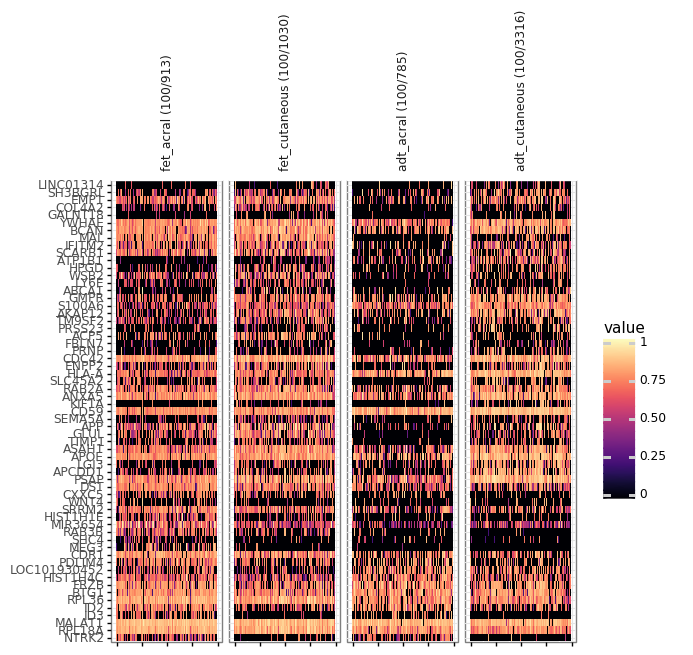

<ggplot: (-9223363288165008966)>


In [225]:
gene_order = master_common.gene.tolist()
input_adata = adata_subset2_trimmed[adata_subset2_trimmed.obs.dev_subtype != 'neo_foreskin']
n_cells = 100
groupby = 'dev_subtype'

type_order = ['fet_acral','fet_cutaneous','adt_acral','adt_cutaneous']

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df[groupby] = input_adata.obs[groupby].tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df[groupby] == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample[groupby] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
# ### gene clustering
# data = compiled_rows.iloc[:,:-2].T.values

# cluster = AgglomerativeClustering(n_clusters=n_clust, 
#                                   affinity='euclidean', 
#                                   linkage='ward')  
# labels = cluster.fit_predict(data).tolist()
# label_df = pd.DataFrame({'gene':compiled_rows.iloc[:,:-2].columns.values,
#                          'label':labels})
# gene_order = label_df.sort_values('label').gene.tolist()
# ###

compiled_rows_melt = pd.melt(compiled_rows, id_vars=[groupby,'idx'])
compiled_rows_melt[groupby] = (compiled_rows_melt[groupby]
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (6,6)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid(f'~{groupby}', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

print(plot)


### (decommissioned) MWU test irrespective of adult or fetal labels

In [26]:
# # To isolate acral-specific expression, the union of age-independent genes 
# #between acral and cutaneous gene sets are tested for differential expression

# input_adata = adata_subset2_trimmed
# genes = adata_subset2.var_names.tolist()

# # Which acral or cutanesous-specific genes are NOT significantly different between FET and ADT?
# alpha = 0.05
# adj_alpha = alpha / (len(genes) * 2)

# type_specific_df = pd.DataFrame()
# for subtype in ['acral', 'cutaneous']:
#     slice_df = input_adata[[x == subtype for x in input_adata.obs.subtypes]]
#     cat, prep_slice = prepare_dataframe(slice_df,
#                                      var_names = genes,
#                                      groupby = 'dev_stage')
#     fet_splice = (prep_slice[[x == 'fet' for x in prep_slice.index]]
#                   .rank(pct=True, axis = 1, method = 'min'))
#     nfet_splice = (prep_slice[[x == 'adt' for x in prep_slice.index]]
#                    .rank(pct=True, axis = 1, method = 'min'))

#     stat_pval_tuple = parallel_mwu(genes, 
#                                fet_splice, 
#                                nfet_splice, 
#                                'two-sided',
#                                usable_cores)
#     stat_list = stat_pval_tuple[0]
#     pval_list = stat_pval_tuple[1]
#     tmp_df = (pd.DataFrame({'gene':genes,
#                              'stat_1':stat_list,
#                              'pval_1':pval_list
#                             })
#               )
#     tmp_df['subtypes'] = subtype
#     tmp_df['pass'] = [x < adj_alpha for x in tmp_df['pval_1']]
#     type_specific_df = type_specific_df.append(tmp_df)

# testable = type_specific_df[type_specific_df['pass'] == False]['gene'].value_counts()
# testable = testable[testable == 2]
# testable = testable.index.tolist()

# # Of the identified genes, which exhibit a significant difference between acral and cutaneous cell type

# adj_alpha = alpha / ((len(genes) * 2) + len(testable))
# cat, prep_slice = prepare_dataframe(input_adata,
#                                      var_names = testable,
#                                      groupby = 'subtypes')
# prep_slice = prep_slice[prep_slice.index != 'foreskin']
# cut_input = (prep_slice[[x == 'cutaneous' for x in prep_slice.index]]
#              .rank(pct=True, axis = 1, method = 'min'))
# acr_input = (prep_slice[[x == 'acral' for x in prep_slice.index]]
#              .rank(pct=True, axis = 1, method = 'min'))

# stat_pval_tuple = parallel_mwu(testable, 
#                                cut_input, 
#                                acr_input, 
#                                'two-sided',
#                                usable_cores)
# stat_list = stat_pval_tuple[0]
# pval_list = stat_pval_tuple[1]
# diff_df = (pd.DataFrame({'gene':testable,
#                          'stat_1':stat_list,
#                          'pval_1':pval_list
#                         })
#           )


In [27]:
# # results
# n_print = 10

# diff_df['pass'] = [x < adj_alpha for x in diff_df['pval_1']]
# display(diff_df[diff_df['pass'] == True].sort_values('pval_1').head(n_print))

,gene,stat_1,pval_1,pass
9993,NTRK2,1982532.0,2.747866e-302,True
5273,ID2,1974446.0,2.801952e-184,True
5755,HPGD,4792787.5,1.719574e-92,True
12820,DMKN,4433351.5,4.823464e-59,True
13229,SHC4,3199763.5,1.964759e-39,True
95,RELL1,4284033.0,1.339224e-30,True
11662,YBX1,3018376.0,3.270011e-28,True
8272,NFIB,4332813.0,9.274974e-28,True
12108,YWHAE,4333504.5,4.608305e-26,True
10215,HOTAIRM1,3963329.5,5.878460e-26,True


### Gene look-up

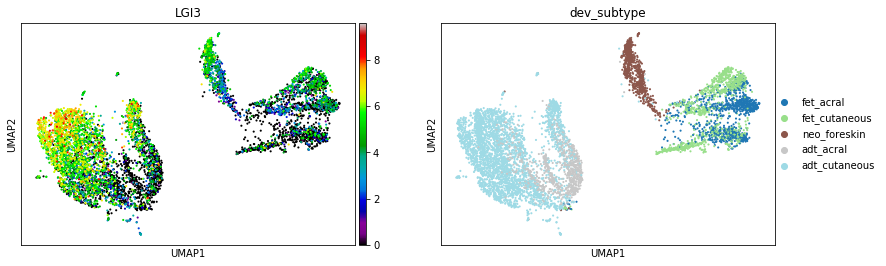

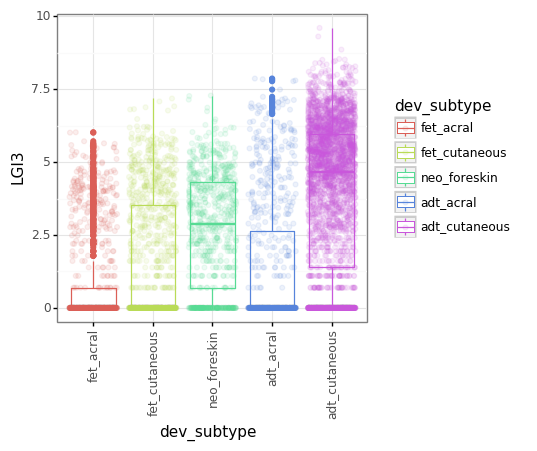

<ggplot: (-9223363288103511173)>
querying 1-1...done.
Finished.
0:  LGI3 
 N/A


In [220]:
# look up gene

gene = 'LGI3'
groupby = 'dev_subtype'
input_adata = adata_subset2_trimmed

sc.pl.umap(input_adata, color = [gene, groupby], cmap='nipy_spectral', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df = plot_df.reset_index()
plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.1)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


### DEV: gene anti-correlation look-up

#### Pearson's correlation

In [ ]:
input_adata = adata_subset2_trimmed
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = input_adata.var_names,
                 groupby = 'dev_stage')

geneoi = 'NTRK2'
    
ref_values = exp_df.loc[:,geneoi].values
stat_list = []
pval_list = []
for i in tqdm.tqdm(exp_df.columns.tolist()):
    cross_values = exp_df.loc[:,i].values
    try:
        stat, pval = stats.pearsonr(ref_values,cross_values)
    except:    
        stat = pval = np.nan
    stat_list.append(stat)
    pval_list.append(pval)

corr_df = pd.DataFrame({'gene':exp_df.columns.tolist(),
                        'stat':stat_list,
                        'pval':pval_list,
                       })
corr_df = corr_df.dropna()

corr_df.sort_values('stat', ascending=True)


#### gene to BSC scatter

In [ ]:
gene = 'NTRK2'

input_adata = adata_subset2_trimmed
cat, bsc_corr = prepare_dataframe(input_adata,
                 var_names = gene,
                 groupby = 'dev_stage')

bsc_corr['bsc'] = input_adata.obs.bsc.values
display(bsc_corr.corr('spearman') ** 2)

plot = (ggplot(bsc_corr)
        + theme_bw()
        + geom_bin2d(aes('NTRK2','bsc'))
       )
plot


### (decommissioned) DEV: Acral vs cutaneous per-sample UMAP
- Analysis of individual samples

In [ ]:
# input_adata = adata_subset2_trimmed

# acral_patients = list(set([y for x,y in zip(input_adata.obs['subtypes'], 
#                                             input_adata.obs['patient']) \
#                            if x == 'acral']))
# input_adata.obs['acral_recluster'] = [y if x in acral_patients else 'drop' \
#                                       for x,y in zip(input_adata.obs['patient'],
#                                                      input_adata.obs['dev_subtype'])]

# type_dict = {'fetal_group':['fet_acral','fet_cutaneous'],
#              'adult_group':['adt_acral', 'adt_cutaneous']}
    
# classify_type(full_adata, input_adata, 'acral_recluster', type_dict, 'acral_recluster')
# classify_type(raw_adata, input_adata, 'acral_recluster', type_dict, 'acral_recluster')

# for grouping in [['fetal_group'], ['adult_group'], ['fetal_group','adult_group']]:
#     n_pcs = 30
#     feature_dict = {'acral_recluster':grouping}
#     adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
#     sc.pp.log1p(adata_subset3) # new
#     sc.pp.highly_variable_genes(adata_subset3,min_mean=0.5,max_mean=10,min_disp=0.5) # new
#     sc.pp.scale(adata_subset3) # new
#     sc.tl.pca(adata_subset3, use_highly_variable = True, n_comps=n_pcs) # new
#     sc.pp.neighbors(adata_subset3,n_pcs=n_pcs) # new
#     sc.tl.umap(adata_subset3, min_dist = 0.25)
#     sc.tl.louvain(adata_subset3, resolution = 0.2)
#     sc.pl.umap(adata_subset3, color=['patient', 'general_location'], ncols = 1)


### (decommissioned) DEV: Acral scoring
- Determine the level of acral-like expression in each of the anatomical locations

In [ ]:
# # scored using top DE gene lists

# gene_n = 10
# dev_stage = 'adt'
# test = 'less' # acr {test} than cut
# results = (fet_v_adt_df
#              .fillna(1)
#              .sort_values('pval_1')
#              .query(f'dev_stage == "{dev_stage}"')
#              .query(f'test == "{test}"')
#           )

# acral_module = results.head(gene_n)['gene'].tolist()
# input_adata = adata_subset2_trimmed[adata_subset2_trimmed.obs.dev_stage == dev_stage]

# input_adata.obs['cell'] = input_adata.obs.index.tolist()
# input_adata.obs['cell'] = (input_adata
#                           .obs['cell']
#                           .astype(str)
#                           .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = acral_module,
#                  groupby = 'cell')
# exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

# if test == 'less':
#     input_adata.obs['acral_score'] = 1-exp_df.loc[:,acral_module].mean(axis=1)
# else:
#     input_adata.obs['acral_score'] = exp_df.loc[:,acral_module].mean(axis=1)

# sc.pl.umap(input_adata, color=['acral_score','anatomical_location'], cmap = 'nipy_spectral', palette = 'tab20')

# summary_df = (input_adata
#               .obs
#               .loc[:,['acral_score','anatomical_location']]
#               .groupby('anatomical_location')
#               .mean()
#               .reset_index()
#              )
# summary_df['normalized_score'] = [(x-min(summary_df['acral_score'].values))/\
#                                   (max(summary_df['acral_score'].values)-min(summary_df['acral_score'].values))\
#                                   for x in summary_df['acral_score']]    
# summ_order = summary_df.sort_values('normalized_score', ascending = False)
# display(summ_order)

# summ_order = summ_order.anatomical_location.tolist()
# plot_df = (input_adata
#             .obs
#             .loc[:,['acral_score','anatomical_location']]).dropna()
# plot_df['anatomical_location'] = (plot_df['anatomical_location']
#                                   .astype(str)
#                                   .astype(CategoricalDtype(summ_order, ordered=True)))
# plotnine.options.figure_size = (4,4)
# print(ggplot(plot_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_boxplot(aes('anatomical_location','acral_score', color = 'anatomical_location'), outlier_alpha = 0)
#       + geom_jitter(aes('anatomical_location','acral_score', color = 'anatomical_location'), alpha = 0.05)
#      )


In [ ]:
# score by single gene of interest
gene = 'HPGD'
input_adata = adata_subset2_trimmed[adata_subset2_trimmed.obs.dev_stage == dev_stage]
summary_df = (input_adata
              .obs
              .loc[:,['anatomical_location']])
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene,
                 groupby = 'anatomical_location')
summary_df[gene] = exp_df[gene].values
plot_df = summary_df

summary_df = (summary_df
              .groupby('anatomical_location')
              .mean()
             )
summary_df['normalized_mean_expression'] = [(x-min(summary_df[gene].values))/\
                                  (max(summary_df[gene].values)-min(summary_df[gene].values))\
                                  for x in summary_df[gene]]   

summ_order = (summary_df
              .sort_values('normalized_mean_expression', ascending = False)
              .reset_index()
             )
display(summ_order)

summ_order = summ_order.anatomical_location.tolist()
plot_df['anatomical_location'] = (plot_df['anatomical_location']
                                  .astype(str)
                                  .astype(CategoricalDtype(summ_order, ordered=True)))
plotnine.options.figure_size = (4,4)
plot = (ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('anatomical_location',gene, color = 'anatomical_location'), outlier_alpha = 0)
      + geom_jitter(aes('anatomical_location',gene, color = 'anatomical_location'), alpha = 0.05)
      + geom_text(plot_df.groupby('anatomical_location').count().reset_index(), 
                  aes('anatomical_location', 
                      max(plot_df[gene]) *1.2,
                      label=gene, 
                      color = 'anatomical_location'), 
                  angle = 90
                 )
      + ylim(0, max(plot_df[gene]) *1.3))
print(plot)



In [ ]:
plot.save('/home/ubuntu/data/DL20181011_melanocyte_test_data/DL20190529_acral_boxplot.pdf', height=5, width=5)


In [ ]:
groupby = 'anatomical_location'
zf_df = pd.DataFrame(plot_df
                         .reset_index()
                         .groupby(groupby)[gene]
                         .apply(lambda x: zero_fraction(x))
                                            ).reset_index().rename(columns = {gene:'zero_fraction'})
zf_df['group'] = 0

print(ggplot(zf_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_line(aes(groupby,'zero_fraction', group=0))
      + geom_point(aes(groupby,'zero_fraction', color = groupby))
     )

In [ ]:
input_adata = adata_subset2_trimmed
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = ['NTRK2','HPGD'],
                 groupby = 'anatomical_location')
input_adata.obs['NTRK2_HPGD'] = exp_df['NTRK2'].values/exp_df['HPGD'].values
input_adata.obs['NTRK2_HPGD'] = input_adata.obs['NTRK2_HPGD'].replace([np.nan,np.inf],0)
sc.pl.umap(input_adata, color = 'NTRK2_HPGD', cmap='nipy_spectral')


### DEV: BSC comparison between acral and cutaneous sites

In [ ]:
input_adata = adata_subset2_trimmed
plot_df = pd.DataFrame(input_adata.obs.groupby(['patient','subtypes'])['bsc'].mean()).reset_index()

# determine samples with acral and cutaneous
filter_df = pd.DataFrame(plot_df['patient'].value_counts())
filter_df = filter_df[filter_df['patient'] == 2]
filter_list = filter_df.index.tolist()

# filter plot_df
plot_df = plot_df[[x in filter_list for x in plot_df.patient]]

# normalize by patient
plot_df['norm_bsc'] = plot_df.groupby('patient')['bsc'].apply(lambda x: x/np.min(x)).values

# plot
plotnine.options.figure_size = (3,3)
plot = (ggplot(plot_df) 
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('patient','norm_bsc', fill = 'subtypes'), stat = 'identity', position = 'dodge')
        + labs(y = "min-normalized BSC-A")
       )
print(plot)


In [ ]:
# acral vs cutaneous expression as function of age

gene = 'MFSD12'
groupby = 'subtypes'
cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df['true_year'] =  input_adata.obs.true_year.tolist()
plot_df = plot_df.reset_index()

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_point(aes('true_year',gene, color = groupby), alpha = 0.05)
      + scale_x_log10()
      + geom_point(pd.DataFrame(plot_df
                                .reset_index()
                                .groupby([groupby, 'true_year'])[gene]
                                .mean())
                   .reset_index(), aes('true_year',gene, color = 'subtypes'), 
                   shape = '_', size = 5)
      + geom_line(pd.DataFrame(plot_df
                                .reset_index()
                                .groupby([groupby, 'true_year'])[gene]
                                .mean())
                   .reset_index(), aes('true_year',gene, color = 'subtypes'))
     )


# Figure 3/4
foreskin analysis

## mel acral and cutaneous-specific heatmap
foreskin mel expresses both acral and cutaneous DE genes

### compile acral and cutaneous DE genes

In [ ]:
# parse adt and fet MWU table
input_adata = adata_subset2_trimmed
gene_n = 20

DE_df = pd.DataFrame()
type_order = ['fet','adt']
for x in tqdm.tqdm(type_order):
    tmpdf = pd.DataFrame()
    if x == 'adt':
        tmpdf['gene'] = fast_DE(input_adata, x,'dev_stage',
                                gene_n=gene_n,
                                reference=[y for y in type_order if not y == x][0])[::-1]
    else:
        tmpdf['gene'] = fast_DE(input_adata, x,'dev_stage',
                                gene_n=gene_n,
                                reference=[y for y in type_order if not y == x][0])
    tmpdf['dev_stage'] = x
    DE_df = DE_df.append(tmpdf)
    
gene_order = DE_df[~DE_df.gene.duplicated(keep='first')].gene.tolist()
    

### mel subtype heatmap

In [ ]:
input_adata = adata_subset2_trimmed
n_cells = 100
type_order = ['fet', 'neo', 'adt']

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df['dev_stage'] = input_adata.obs.dev_stage.tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df.dev_stage == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample['dev_stage'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['dev_stage','idx'])
compiled_rows_melt['dev_stage'] = (compiled_rows_melt['dev_stage']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (7,7)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~dev_stage', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

plot


### mean expression as function of dev_stage

In [ ]:
plot_df = pd.merge((compiled_rows_melt
                     .groupby(['dev_stage','variable'])['value']
                     .mean()
                     .reset_index()
                    ), 
                   DE_df.rename(columns = {'dev_stage':'specific',
                                           'gene':'variable'
                                          }), 
                   'left', 
                   'variable')

plotnine.options.figure_size = (5,5)
print(ggplot(plot_df.dropna())
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_point(aes('dev_stage','value', color='variable'))
      + geom_line(aes('dev_stage','value', 
                      group='variable', color='variable'))
      + facet_wrap('~specific')
     )


## mel foreskin-specific expression

### foreskin vs rest DE gene list

In [ ]:
input_adata = adata_subset2_trimmed
clusterOI = 'neo'
reference= 'rest'  #'rest'
groupby = 'dev_stage'
gene_n = 20

sc.tl.rank_genes_groups(input_adata, groupby=groupby, groups=[clusterOI], method='wilcoxon',reference=reference)
gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]

DE_df = pd.DataFrame({'gene':gene[:gene_n]})
DE_df[groupby] = clusterOI

gene_order = DE_df[~DE_df.gene.duplicated(keep='first')].gene.tolist()
 

### foreskin-specific heatmap

In [ ]:
input_adata = adata_subset2_trimmed
n_cells = 100
type_order = ['fet', 'neo', 'adt']

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df['dev_stage'] = input_adata.obs.dev_stage.tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df.dev_stage == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample['dev_stage'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['dev_stage','idx'])
compiled_rows_melt['dev_stage'] = (compiled_rows_melt['dev_stage']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (7,7)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~dev_stage', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

plot


### foreskin-specific mean expression as function of dev_stage

In [ ]:
plot_df = pd.merge((compiled_rows_melt
                     .groupby(['dev_stage','variable'])['value']
                     .mean()
                     .reset_index()
                    ), 
                   DE_df.rename(columns = {'dev_stage':'specific',
                                           'gene':'variable'
                                          }), 
                   'left', 
                   'variable')

plotnine.options.figure_size = (5,5)
print(ggplot(plot_df.dropna())
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_point(aes('dev_stage','value', color='variable'))
      + geom_line(aes('dev_stage','value', 
                      group='variable', color='variable'))
      + facet_wrap('~specific')
     )


# (decommissioned) DEV: ridge plots

In [ ]:
# # "ridge plots"
# #####################
# genelist = ['SOX2','MITF','TYR','PMEL','NTRK2','ID2']
# groupby = 'dev_subtype'
# # groupby = 'dev_stage'
# print_umaps = False
# print_anno = False
# #####################

# input_adata = adata_subset2
# cat, plot_df = prepare_dataframe(input_adata,
#                             genelist,
#                             groupby
#                            )
# plot_df = plot_df.reset_index()
# plot_df = pd.melt(plot_df, id_vars=groupby)
# plot_df = plot_df.sample(frac = 0.1)

# plotnine.options.figure_size = (8,8)
# print(ggplot(plot_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90),
#               aspect_ratio = 1
#              )
#       + facet_grid(f'{groupby} ~ variable')
#       + geom_histogram(aes('value','..density..', fill='variable'))
#      )

# if print_umaps == True:
#     sc.pl.umap(input_adata, color = [groupby]+genelist, cmap='nipy_spectral', 
#                palette = 'tab20', legend_loc = 'on data', ncols = 3)

# if print_anno == True:
#     out = symbol2field(genelist)
#     output = [print(f'{idx}: ', 
#            x['query'],
#            '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                     x['query'],
#                                                                     '\n','N/A') for idx, x in enumerate(out)]


# DEV: Cancer correlation

### Correlation to bulk melanoma cell lines

#### Bulkized ranked correlation

In [ ]:
# download raw data from s3
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

# import data from s3
for file in ['acraldata.MvA.counts.csv']:
    ! aws s3 cp s3://{s3dir}/{file} {wkdir}/

input_adata = adata_subset2_trimmed
high_var_genes = (input_adata.var['highly_variable'][input_adata.var['highly_variable'] == True]).index.tolist()

cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
                           index_col=0)
cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
                .sort_index())
# match genes to adata
cell_line_df = cell_line_df[[x in high_var_genes for x in cell_line_df.index]]
cell_line_df = cell_line_df.apply(np.log1p)
# remove duplicate gene
cell_line_df = cell_line_df[~cell_line_df.index.duplicated(keep='first')]
cell_line_df = cell_line_df.T
cell_line_df['cancer_origin'] = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in cell_line_df.index]
cell_line_df = cell_line_df.set_index('cancer_origin')
cell_line_df = (cell_line_df
                .reset_index()
                .groupby('cancer_origin')
                .mean()
                .T
                .reset_index()
               )

# return only genes found in both sets
cat, gene_df = prepare_dataframe(input_adata,
                         cell_line_df['index'].tolist(),
                         'dev_subtype')
gene_df = (gene_df
           .reset_index())
gene_df['dev_subtype'] = gene_df['dev_subtype'].astype(str)
gene_df = (gene_df
           .groupby('dev_subtype')
           .mean()
           .T
           .reset_index()
          )

cross_merge = pd.merge(cell_line_df, gene_df, 'inner', 'index')
cross_merge = cross_merge.corr(method = 'spearman')**2
cross_merge = cross_merge.reset_index()
cross_melt = pd.melt(cross_merge, id_vars='index')
cross_melt['val_label'] = [f'{x:.2g}' for x in cross_melt['value']]
plotnine.options.figure_size = (4,4)
print(ggplot(cross_melt)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('index','variable',fill='value'))
      + geom_text(aes('index','variable',label='val_label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('variance explained')
     )


#### Bulkized ranked correlation scatter

In [ ]:
# example correlated expression plot
ref1='AM'
ref2='fet_acral'
run_full = True

cross_merge = pd.merge(cell_line_df, gene_df, 'inner', 'index')

plot = ggplot(cross_merge) + geom_point(aes(ref1,ref2), alpha = 0.2)

plot = (plot
      + theme_bw()
#       + scale_x_log10()
#       + scale_y_log10()
     )
print(plot)


### Correlate to single cell melanoma biopsies

#### Bulkized ranked correlation

##### ingest data

In [ ]:
# ingest data
sc_mel_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/cancer_ext_data/GSE72056_melanoma_single_cell_revised_v2.txt',
           sep = '\t')

sc_mel_counts = (sc_mel_df.iloc[3:,:]
                 .rename(columns = {'Cell':'gene'})
                 .set_index('gene')
                 .T
                )
# add patient annotations
sc_mel_counts['cancer_patient'] = ['mel_{}'.format(int(x)) for x in sc_mel_df.iloc[0,1:]]
# remove non-malignant cells
sc_mel_counts = sc_mel_counts[sc_mel_df.iloc[1,1:] == 2]
# remove duplicate genes
sc_mel_counts = (sc_mel_counts
                 .iloc[:,~sc_mel_counts.columns.duplicated(keep = 'first')]
                )

# filter based on Fig1C constituents from paper
mel_cell_id = [53,58,60,72,74,78,79,80,81,84,88,89,94]
sc_mel_counts = sc_mel_counts[[int(x.split('_')[1]) in mel_cell_id for x in sc_mel_counts.cancer_patient]]

patient_values = sc_mel_counts['cancer_patient'].values.tolist()


# bulkized mean cancer expression
melanoma_bulkized = sc_mel_counts.groupby('cancer_patient').mean().T.reset_index()

# bulkized mean primary expression
input_adata = adata_subset2_trimmed

cat,primary_df = prepare_dataframe(input_adata,
                           input_adata.var_names,
                           'dev_subtype'
                          )
primary_df = (primary_df
              .reset_index()
             )
primary_df['dev_subtype'] = primary_df['dev_subtype'].astype(str)
primary_df = (primary_df
              .groupby('dev_subtype')
              .mean()
              .T
              .reset_index()
              .rename(columns = {'index':'gene'})
             )


##### covariance matrix

In [ ]:
# covariance matrix

corr_df = pd.merge(melanoma_bulkized, primary_df, 'inner', 'gene')
# only highly-variable genes
high_var_genes = (input_adata.var['highly_variable'][input_adata.var['highly_variable'] == True]).index.tolist()
corr_df = corr_df.loc[[x in high_var_genes for x in corr_df['gene']]]
corr_df = corr_df.corr('spearman') ** 2
corr_df = corr_df.reset_index()
cross_melt = pd.melt(corr_df, id_vars='index')
cross_melt['val_label'] = [f'{x:.2f}' for x in cross_melt['value']]
var_order =['adt_acral',
            'adt_cutaneous',
            'fet_acral',
            'fet_cutaneous',
            'neo_foreskin',
            'mel_53',
             'mel_59',
             'mel_60',
             'mel_65',
             'mel_71',
             'mel_75',
             'mel_78',
             'mel_79',
             'mel_80',
             'mel_81',
             'mel_82',
             'mel_84',
             'mel_88',
             'mel_89',
             'mel_94']
cross_melt['variable'] = (cross_melt['variable']
                         .astype(str)
                         .astype(CategoricalDtype(var_order
                                                 )
                                )
                         )
cross_melt['index'] = (cross_melt['index']
                         .astype(str)
                         .astype(CategoricalDtype(var_order
                                                 )
                                )
                         )

plotnine.options.figure_size = (8,8)
print(ggplot(cross_melt)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('index','variable',fill='value'))
      + geom_text(aes('index','variable',label='val_label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('variance explained')
     )


##### linear regression

In [ ]:
n_print = 10
ref1 = 'melanoma'
ref2 = 'adt_cutaneous'

compare_df = pd.merge(pd.DataFrame(sc_mel_counts.mean()).reset_index().rename(columns = {0:'melanoma'}), 
                      primary_df, 
                      'inner', 'gene')
ref1_vec = compare_df[ref1].values.reshape(-1, 1)
ref2_vec = compare_df[ref2].values.reshape(-1, 1)

y_predicted, y_residuals = regress(ref1_vec, ref2_vec)

plot_df = pd.DataFrame({ref1:ref1_vec.flatten(),
                        ref2:ref2_vec.flatten(),
                        'fitted':y_predicted.flatten(),
                        'resid':y_residuals.flatten()
                       })
plot_df['group'] = 'group'
plot_df['sq_resid'] = plot_df['resid'] ** 2
plot_df['norm_resid'] = plot_df['resid']/plot_df['fitted']
plot_df['gene'] = compare_df.gene.values

plot_df_slice = plot_df.sort_values('sq_resid', ascending=False).head(n_print)
plot_df_slice['idx'] = [x for x in range(len(plot_df_slice))]
plot_df_slice = plot_df_slice.sort_values('norm_resid')

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + geom_point(aes(ref1, ref2), alpha = 0.1)
      + geom_line(aes(ref1, 'fitted', group='group'), color = 'red')
      + geom_label(plot_df_slice, 
                  aes(ref1, ref2, label = 'idx'), color = 'red', size = 7)
#       + scale_y_log10()
#       + scale_x_log10()
     )
display(plot_df_slice)


In [ ]:
sc.pl.umap(full_adata, color = 'MTRNR2L10', cmap = 'nipy_spectral')


##### (decommissioned) Cancer-normal ratio score

In [ ]:
# input_adata = adata_subset2_trimmed

# program_df = pd.read_csv('s3://daniel.le-work/MEL_project/axl_mitf_genes.csv')
# cancer_module = plot_df_slice.gene.tolist()[:10]
# normal_module = plot_df_slice.gene.tolist()[-10:]

# modules_dict = {'cancer_module':cancer_module,
#                 'normal_module':normal_module,
#                }

# input_adata.obs['cell'] = input_adata.obs.index.tolist()
# input_adata.obs['cell'] = (input_adata
#                           .obs['cell']
#                           .astype(str)
#                           .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = [x for key,value in modules_dict.items() for x in value],
#                  groupby = 'cell')
# exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

# for key,value in modules_dict.items():
#     input_adata.obs[key] = exp_df.loc[:,value].mean(axis=1)
#     sc.pl.umap(input_adata, color=[key], cmap = 'magma_r', palette = 'tab20')

# input_adata.obs['can_norm'] = input_adata.obs['cancer_module']/input_adata.obs['normal_module']
# sc.pl.umap(input_adata, color=['can_norm'], cmap = 'magma_r', palette = 'tab20')


# # density of cancer score
# groupby = 'dev_subtype'
# can_norm_df = input_adata.obs.loc[:,['can_norm',groupby]]
# plotnine.options.figure_size = (3,3)
# plot = (ggplot(can_norm_df)
#         + theme_bw()
#         + theme(axis_text_x = element_text(angle=90))
#         + geom_boxplot(aes(groupby,'can_norm'))
# #         + scale_y_log10()
#        )
# plot



##### UMAP of AXL vs MITF programs

In [ ]:
input_adata = adata_subset2_trimmed

program_df = pd.read_csv('s3://daniel.le-work/MEL_project/axl_mitf_genes.csv')
AXL_module = [x for x in program_df.axl_program.tolist() if x in input_adata.var_names.tolist()]
MITF_module = [x for x in program_df.mitf_program.tolist() if x in input_adata.var_names.tolist()]

modules_dict = {'AXL_module':AXL_module,
                'MITF_module':MITF_module,
               }

input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = [x for key,value in modules_dict.items() for x in value],
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

for key,value in modules_dict.items():
    input_adata.obs[key] = exp_df.loc[:,value].mean(axis=1)
    sc.pl.umap(input_adata, color=[key], cmap = 'magma', palette = 'tab20')

input_adata.obs['AXL_MITF'] = input_adata.obs['AXL_module']/input_adata.obs['MITF_module']
sc.pl.umap(input_adata, color=['AXL_MITF'], cmap = 'nipy_spectral', palette = 'tab20')


##### Scatter of AXL vs MITF programs: cell-wise

In [ ]:
groupby = 'dev_subtype'
plot_df = input_adata.obs.loc[:, ['AXL_module','MITF_module',groupby]]

plotnine.options.figure_size = (5,5)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('AXL_module', 'MITF_module'), alpha = 0.1)
        + facet_wrap(f'~{groupby}')
       )
plot


##### AXL-MITF cell-wise scatter

In [ ]:
melanoma_df = sc_mel_counts.drop(['cancer_patient'], axis=1)
genesoi = [x for x in set(AXL_module + MITF_module) if x in melanoma_df.columns.tolist()]
melanoma_df = melanoma_df.loc[:, genesoi]
melanoma_df = melanoma_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

# plot scatter
mel_mod_df = pd.DataFrame({'MITF_module':(melanoma_df.loc[:,[x for x in set(MITF_module) if x in melanoma_df.columns.tolist()]]
                                       .mean(axis=1)
                                       .values),
                         'AXL_module':(melanoma_df.loc[:,[x for x in set(AXL_module) if x in melanoma_df.columns.tolist()]]
                                       .mean(axis=1)
                                       .values),
                         'patient':patient_values      
                       })
mel_mod_df['AXL_MITF'] = mel_mod_df['AXL_module'] / mel_mod_df['MITF_module']
mel_mod_df['type'] = 'cancer'
mel_mod_df['dev_subtype'] = 'cancer'

plot = (ggplot(mel_mod_df)
        + theme_bw()
        + geom_point(aes('AXL_module', 'MITF_module', color = 'patient'), alpha = 0.1)
       )
plot

##### AXL/MITF ratio density between primary and melanoma

In [ ]:
norm_mod_df =input_adata.obs.loc[:,['AXL_MITF','dev_subtype']]
norm_mod_df['type'] = 'normal'

mod_df = mel_mod_df.loc[:,['AXL_MITF','type','dev_subtype']].append(norm_mod_df)

plot = (ggplot(mod_df)
        + theme_bw()
        + geom_density(aes('AXL_MITF', color = 'type'))
       )
plot


# (decommissioned) DEV: cellphone db testing

In [ ]:
# create new classes
full_adata.obs['dev_subtype_celltype'] = [f'{x}_{y}' for x,y in zip(full_adata.obs['dev_subtype'], full_adata.obs['class_1'])]
full_adata.obs['dev_subtype_celltype'] = full_adata.obs['dev_subtype_celltype'].astype(str).astype(CategoricalDtype(list(set(full_adata.obs['dev_subtype_celltype']))))
set(full_adata.obs['dev_subtype_celltype'])


In [ ]:
def calc_pct_expr(col):
    return np.sum(col)/len(col)

# cellphone db methods:
# ref: https://www.nature.com/articles/s41586-018-0698-6#Sec9
# >10% ligand and receptor in cell types
# permutation test te determine p-value
# HOWEVER: https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1479&context=jmasm
# above authors show, using simulations, that WMU test has higher power (ability to correctly reject null)

# input adata
alpha = 0.1
input_adata = full_adata
feature_axis = 'class_1' # must be binary!
classes = ['MEL', 'KRT']
input_adata = input_adata[[x in classes for x in input_adata.obs[feature_axis]]]

# cast counts data
cat, gene_df = prepare_dataframe(input_adata,
                         input_adata.var_names,
                         feature_axis)

# pull interactions list
interact_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190307_interactions_cellphonedb.csv')
interact_df = interact_df.loc[:,['entry_name_a', 'entry_name_b']].dropna()
interact_df['entry_name_a'] = [x.split('_')[0] for x in interact_df['entry_name_a']]
interact_df['entry_name_b'] = [x.split('_')[0] for x in interact_df['entry_name_b']]

# non-zero expression df
nz_df = gene_df.astype(bool).reset_index().groupby(feature_axis).apply(calc_pct_expr)

# filter nz df by interaction genes
interaction_genes = list(set(interact_df['entry_name_a'].values.tolist() + interact_df['entry_name_b'].values.tolist()))
nz_df = (nz_df
         .loc[:,interaction_genes]
         .T
         .dropna())

# filter nz df by heuristic: pct_exp > 0.1 in both classes
nz_df = nz_df[[x >= 0.1 and y >= 0.1 for x,y in zip(nz_df[classes[0]], nz_df[classes[1]])]]
passed_genes = nz_df.index.tolist()

# filter interactions that pass heuristic
interact_df = interact_df[[x in passed_genes and y in passed_genes for x,y in zip(interact_df['entry_name_a'],interact_df['entry_name_b'])]]
interact_df['pairs'] = [f'pair_{x}' for x in range(len(interact_df))]
interact_df = pd.melt(interact_df, id_vars='pairs').sort_values('pairs')
interact_df = interact_df.drop('variable', axis = 1)
try:
    # mwu test for differential gene expression between classes
    stat_list = []
    pval_list = []
    test_count = 0
    for goi in interact_df.value:
        expr = gene_df.loc[:, [goi]].reset_index()
        c1_expr = expr[[x == classes[0] for x in expr[feature_axis]]][goi].values
        c2_expr = expr[[x == classes[1] for x in expr[feature_axis]]][goi].values
        stat,pval = stats.mannwhitneyu(c1_expr, c2_expr, alternative='two-sided')
        test_count += 1
        stat_list.append(stat)
        pval_list.append(pval)

    interact_df['intra_gene_diff'] = pval_list


    # mwu and mean ratio for differential paired gene expression within classes
    intergene_df = pd.DataFrame()
    for pair in list(set(interact_df.pairs)):
        gois = interact_df[interact_df.pairs == pair].value.values.tolist()
        goi1 = gois[0]
        goi2 = gois[1]
        expr = gene_df.loc[:, gois].reset_index()
        ratio_sign_list = []
        stat_list = []
        pval_list = []
        for class_val in classes:
            g1_expr = expr[[x == class_val for x in expr[feature_axis]]][goi1].values
            g2_expr = expr[[x == class_val for x in expr[feature_axis]]][goi2].values
            # calc ratio g1/g2
            ratio_sign = np.sign(np.mean(g1_expr) - np.mean(g2_expr))
            ratio_sign_list.append(ratio_sign)
            # calc mwu test
            stat,pval = stats.mannwhitneyu(g1_expr, g2_expr, alternative='two-sided')
            test_count += 1
            stat_list.append(stat)
            pval_list.append(pval)
        tmp_df = pd.DataFrame({'sign':ratio_sign_list,
                      'stat':stat_list,
                      'pval':pval_list,
                      'class_var':classes
                     })
        tmp_df['pairs'] = pair
        intergene_df = intergene_df.append(tmp_df)

    # parse intergene df and update interact df with pass/fail
    filter_df = pd.DataFrame()
    for pair in list(set(intergene_df.pairs)):
        slice_df = intergene_df[intergene_df.pairs == pair]
        sign_list = slice_df['sign'].values.tolist()
        pval_list = slice_df['pval'].values.tolist()
        class_list = slice_df['class_var'].values.tolist()
        filter_slice = pd.DataFrame({'pairs':[pair],
                                  'mutually_opposed':[sign_list[0] != sign_list[1]],
                                  f'intra_{class_list[0]}_diff':[pval_list[0]],
                                  f'intra_{class_list[1]}_diff':[pval_list[1]]
                                 })
        filter_df = filter_df.append(filter_slice)

    interact_df = pd.merge(interact_df, filter_df, 'left','pairs')
    # final filters: diametrically opposed expression within class, between gene pairs
    interact_df = interact_df[interact_df.mutually_opposed == True]
    # final filters: independence test between classes for each gene in pairs &
    #independence test within classes for each gene in pairs
    for pair in list(set(interact_df.pairs)):
        if np.sum((interact_df[intergene_df.pairs == pair]
                  .loc[:,[x.startswith('intra') for x in interact_df.columns]]
                  .values) < (alpha / test_count)) != 6:
            interact_df =  interact_df[interact_df.pairs != pair]
        else:
            pass

    if len(interact_df) == 0:
        raise exception
    else:
        for pair in list(set(interact_df.pairs)):
            df_slice = interact_df[interact_df.pairs == pair]
            display(df_slice)
            gois = df_slice.value.values.tolist()
            
            sc.pl.umap(input_adata, color = gois+[feature_axis], cmap = 'nipy_spectral')
            
            plot_df = gene_df.loc[:,gois].reset_index()
            plot_df = pd.melt(plot_df, id_vars=feature_axis)
            print(ggplot(plot_df)
                  + theme_bw()
            #       + geom_boxplot(aes(feature_axis, 'value', color = 'variable'))
                  + geom_jitter(aes('variable', 'value', color = 'variable'), alpha = 0.5)
                  + facet_wrap(f'~{feature_axis}', scales = 'free')
                 )
            
            out = symbol2field(gois)
            output = [print(f'{idx}: ', 
                   x['query'],
                   '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                            x['query'],
                                                                            '\n','N/A') for idx, x in enumerate(out)]
except:
    print('No significant interactions')
    

# (decommissioned) DEV: KRT analysis


## n_genes

In [ ]:
# n_genes
sc.pl.umap(adata_subset1_KRT, color = ['n_genes', 'age', 'n_counts', 'KRT10'], cmap = 'nipy_spectral', ncols = 2)
krt_ngenes = adata_subset1_KRT.obs.loc[:,['n_genes','age_group']].reset_index()
cat, krt_genes = prepare_dataframe(adata_subset1_KRT, adata_subset1_KRT.var_names, 'age_bin')
krt_genes = krt_genes.reset_index()
krt_df = pd.concat([krt_genes, krt_ngenes], axis = 1)


In [ ]:
print(ggplot(krt_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('age_bin','n_genes'))
     )

print(ggplot(krt_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('age_group','n_genes'))
     )

## acral vs cutaneous

In [ ]:
master_diff = pd.DataFrame()
for test in ['less','greater']:
    for dev_stage in ['adt', 'fet']:
        print(f'calculating {dev_stage} acral {test} than cutaneous...')
        input_slice = adata_subset1_KRT[adata_subset1_KRT.obs.dev_stage == dev_stage]
        genes = input_slice.var_names.tolist()
        cat, prep_slice = prepare_dataframe(input_slice,
                                             var_names = genes,
                                             groupby = 'subtypes')
        prep_slice = prep_slice[prep_slice.index != 'foreskin']
        cut_input = (prep_slice[[x == 'cutaneous' for x in prep_slice.index]]
                     .rank(pct=True, axis = 1, method = 'min'))
        acr_input = (prep_slice[[x == 'acral' for x in prep_slice.index]]
                     .rank(pct=True, axis = 1, method = 'min'))

        stat_pval_tuple = parallel_mwu(genes, 
                                       acr_input,
                                       cut_input,  
                                       test,
                                       usable_cores)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        diff_df = (pd.DataFrame({'gene':genes,
                                 'stat_1':stat_list,
                                 'pval_1':pval_list
                                })
                  )
        diff_df['dev_stage'] = dev_stage
        diff_df['test'] = test
        master_diff = master_diff.append(diff_df)


In [ ]:
print_n = 10
dev_stage = 'adt'
test = 'greater' # acr {test} than adt

(master_diff
 .query(f'dev_stage == "{dev_stage}"')
 .query(f'test == "{test}"')
 .sort_values('pval_1')
 .head(print_n))

In [ ]:
# need to subset on cell-specific dev_stage
full_adata.obs['cell_dev_subtype'] = [f'{x}_{y}' for x,y in zip(full_adata.obs.class_1, full_adata.obs.dev_subtype)]

gene = 'NTRK2'
groupby = 'cell_dev_subtype'

input_adata = full_adata[[x == 'MEL' or x == 'KRT' for x in full_adata.obs.class_1]]
input_adata = input_adata[input_adata.obs.dev_stage == dev_stage]
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = cycling_module,
                 groupby = 'patient')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene
input_adata.obs['cycling_module'] = exp_df.loc[:,cycling_module].mean(axis=1).values

sc.pl.umap(input_adata, color = [gene, groupby, 'cycling_module'], cmap='nipy_spectral', palette = 'tab20')
# sc.pl.umap(full_adata, color = [gene, 'dev_subtype','cycling_module'], cmap='nipy_spectral', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df = plot_df.reset_index()
plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.1)
      + geom_point(plot_df.groupby(groupby).mean().reset_index(), aes(groupby,gene,color=groupby), 
                   shape = '_', size = 10)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


### DEV: cellphoneDB to see if there is any signaling

In [ ]:
gene_n = 100
genesOI = (master_diff
         .query(f'dev_stage == "{dev_stage}"')
         .query(f'test == "{test}"')
         .sort_values('pval_1')
         .head(gene_n))['gene'].tolist()

interact_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190307_interactions_cellphonedb.csv')
interact_df = interact_df.loc[:,['entry_name_a', 'entry_name_b']].dropna()
interact_df['entry_name_a'] = [x.split('_')[0] for x in interact_df['entry_name_a']]
interact_df['entry_name_b'] = [x.split('_')[0] for x in interact_df['entry_name_b']]

interact_df['pass'] = [x in genesOI or y in genesOI for x,y in zip(interact_df.entry_name_a, interact_df.entry_name_b)]
interact_df[interact_df['pass'] == True]


### DEV: Test model for technical noise - MEL dendrite stuck to KRT

In [ ]:
input_adata = full_adata
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = 'NTRK2',
                 groupby = 'cell_dev_subtype')

plot_df = input_adata.obs.loc[:,['bKRT_module','cell_dev_subtype']]
plot_df['NTRK2'] = exp_df['NTRK2'].tolist()
plot_df = plot_df[[(x.startswith('MEL') or x.startswith('KRT')) and not x.endswith('foreskin') for x in plot_df.cell_dev_subtype]]

plotnine.options.figure_size = (8,8)
print(ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes('NTRK2', 'bKRT_module'))
      + facet_wrap('~cell_dev_subtype')
     )



In [ ]:
(plot_df.groupby('cell_dev_subtype').corr('spearman') ** 2).dropna()

# Pickle utility

In [ ]:
# pickle adatas
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

for objname in ['adata_subset2_trimmed']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))

In [ ]:
sc.pl.umap(full_adata, color = ['HPGD',
                               ], cmap = 'nipy_spectral', ncols = 2)